# Homework #4
 
1. Extraction protocol
2. EDA
3. Data cleansing
 
### Part 1 - Extraction protocol
 
Fill the excel file with the variables, indicating the values required in the file.

### Part 2 - EDA
 
#### 2.1 - Descriptive statistics
 
Generate a table showing the minimum, maximum, median, IQR, mean and standard deviation for each variable. Use the functions summary (in R), describe (in Python), or use the Table1 function from the mechkar package

In [3]:
if (!require("car")) install.packages("car")
if (!require("tibble")) install.packages("tibble")
if (!require("dplyr")) install.packages("dplyr")
library(DBI)
library(odbc)

Loading required package: car

Warning message:
"package 'car' was built under R version 3.6.2"
Loading required package: carData

Loading required package: tibble

Loading required package: dplyr


Attaching package: 'dplyr'


The following object is masked from 'package:car':

    recode


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [2]:
####################  FUNCTIONS  ###########################################
#### Usage:
####   x: character vector with the name of the variables
####   y: the name of the strata variable (optional)
####   rn: character vector with the text we want to replace the variable names
####   data: the dataset to be used
####   miss: include missing statistics: [0=none, 1=only for categorical variables, 2=for all variables]
####   excel: export the table to excel [0=no, 1=yes]
####   excel_file: the name of the excel file we want to save the table (optional)
####
###################

Table1 <- function(x=NULL, y=NULL, rn=NULL, data=NULL, miss=3, catmiss=TRUE, formatted=TRUE, categorize=FALSE,
                    factorVars=NULL, maxcat=10, delzero=TRUE, decimals=1, messages=TRUE, excel=0, excel_file=NULL,
                    debug=FALSE) {
  ### define sub-functions
  options(warn=-1)
  Del <- NULL
  Pop <- NULL
  n <- NULL
  g1 <- function(var)c(Mean=mean(var,na.rm=TRUE), SD=stats::sd(var,na.rm=TRUE))
  g2 <- function(var)c(Median=stats::median(var,na.rm=TRUE), IQR=stats::quantile(var,c(0.25,0.75),na.rm=TRUE))
  msg <- NULL

  ### function for transforming variables to factors
  setFactors <- function(data=data, factorVars=factorVars, catmiss=catmiss, maxcat=maxcat) {
    #print(factorVars)
    if(is.null(factorVars)==T) {
      aa <- sapply(sapply(data, unique), length)
      factorVars <- names(which(aa <= maxcat))
    }
    #print(factorVars)
    for (v in factorVars) {
      ct <- ifelse( ((is.null(factorVars)==F & (v %in% factorVars)) | (is.null(factorVars)==T & length(unique(data[[v]])) <= maxcat)),1,0)
      if (ct == 1) {
        data[[v]] <- factor(data[[v]])
        if(catmiss == T & sum(is.na(data[[v]])==T) > 0) {
          data[[v]] <- factor(data[[v]],levels=c(levels(data[[v]]),"Missing"))
          data[[v]][which(is.na(data[[v]])==T)] <- "Missing"
        }
      }
    }
    return(data)
  }
  ### proceed to convert varibles to factors
  if (categorize == T | is.null(factorVars)==F ) {
    data <- setFactors(data, factorVars, catmiss, maxcat)
  }

  getSimpleTable  <- function(x=x, rn=rn, data=data, miss=miss, catmiss=catmiss,formatted=formatted,
                              categorize=categorize,maxcat=maxcat, delzero=delzero) {
    if (is.null(x)==TRUE) { x <- names(data)}
    if (is.null(rn)==TRUE) { rn <- x}
    ln <- length(x)
    pb <- utils::txtProgressBar(min=0,max=ln,style=3)
    msg <- NULL
    ### define the column names
    tableaaaa <- cbind(Del="Del",V1="Variables",V2="Categories",n="n","Population")
    tablebbbb <- cbind(Del="Del",V1="Variables",V2="Categories",n="n",val1="val1",val2="val2",val3="val3")
    tbl1 <- cbind(0,"Individuals","n",n=1, nrow(data))
    tbl2 <- cbind(0,"Individuals","n",n=1, nrow(data),NA,NA)
    tableaaaa <- rbind(tableaaaa,tbl1)
    tablebbbb <- rbind(tablebbbb,tbl2)
    q <- 1
    n <- 1
    ii <- 1
    for (v in x)
    {
      if (v %in% names(data)) {
        ### define if the actual variable has to be treated as numeric or factor
        ct <- ifelse(is.numeric(data[[v]])==T & categorize==T &
                       ((is.null(factorVars)==F & (v %in% factorVars)) |
                          (is.null(factorVars)==T & length(unique(data[[v]])) <= maxcat)),1,0)
        ### treat as numeric
        if (length(unique(data[v]))==0) {
          if (messages==T) {
            #print(paste("The variable",v,"has no data... avoided"))
            msg <- c(msg, paste("The variable",v,"has no data... avoided"))
          }
        } else if (inherits(data[[v]], "Date")==TRUE) {
          if (messages==T) {
            msg <- c(msg, paste("The variable",v,"is a date. Dates are not allowed in Table1... avoided"))
          }
        } else if (is.numeric(data[[v]])==T & ct==0) {
          ## report mean and standard deviation
          t_n <- g1(data[[v]])
          tp <- paste(format(round(t_n[1],decimals),nsmall=1,big.mark=",")," (", format(round(t_n[2],decimals),nsmall=1,big.mark=","),")",sep="")
          tbl1 <- cbind(0,rn[q],"Mean (SD)",n=1, tp)
          tbl2 <- cbind(0,rn[q],"Mean (SD)",n=1,t_n[1],t_n[2],NA)
          tableaaaa <- rbind(tableaaaa,tbl1)
          tablebbbb <- rbind(tablebbbb,tbl2)
          ## report median and Interquartile ranges (25%,75%)
          t_n <- g2(data[[v]])
          tp <- paste(format(round(t_n[1],decimals),nsmall=1,big.mark=",")," (", format(round(t_n[2],decimals),nsmall=1,big.mark=","),"-", format(round(t_n[3],decimals),nsmall=1,big.mark=","), ")",sep="")
          tbl1 <- cbind(0,rn[q],"Median (IQR)",n=2, format(tp,big.mark=","))
          tbl2 <- cbind(0,rn[q],"Median (IQR)",n=2,t_n[1],t_n[2],t_n[3])
          tableaaaa <- rbind(tableaaaa,tbl1)
          tablebbbb <- rbind(tablebbbb,tbl2)
          ## report number and percent of missing
          if (miss >= 1) {
            datams <- subset(data,is.na(data[[v]])==T)
            if (nrow(datams)>0) {
              data$cnt <- 1
              datams$cnt <- 1
              t_n <- table(data$cnt)
              t_m <- sum(datams$cnt)
              tp <- paste(format(t_m,big.mark=",")," (",format(round((t_m/t_n)*100,decimals),nsmall=1,big.mark=","),"%)",sep="")
              tbl1 <- cbind(0,rn[q],"Missing (%)",n=3, tp)
              tbl2 <- cbind(0,rn[q],"Missing (%)",n=3, t_m, (t_m/t_n)*100, NA)
            } else {
              tbl1 <- cbind(1,rn[q],"Missing (%)",n=3, " -- ")
              tbl2 <- cbind(1,rn[q],"Missing (%)",n=3, NA, NA, NA)
            }
            tableaaaa <- rbind(tableaaaa,tbl1)
            tablebbbb <- rbind(tablebbbb,tbl2)
          }
        } else {
          t_n <- table(data[[v]])
          ttotal <- sum(t_n)
          nm <- row.names(t_n)
          for (f in 1:length(nm)) {
            del1 <- ifelse(length(nm)==2 & (nm[f]=="No" | nm[f]=="no" | nm[f]==0 | nm[f]=="0" | nm[f]=="None" | nm[f]=="none"),1,0)
            tp <- t_n[f] / ttotal * 100
            pct <- paste(format(round(t_n[f],decimals),nsmall=0,big.mark=",")," (", format(round(tp,decimals),nsmall=1,big.mark=","), "%)",sep="")
            tbl1 <- cbind(del1,rn[q],nm[f],n=f, pct)             ########### delete rows 0/1 !!!!!!!!!
            tbl2 <- cbind(del1,rn[q],nm[f],n=f, t_n[f], tp, NA)  ########### delete rows 0/1 !!!!!!!!!
            tableaaaa <- rbind(tableaaaa,tbl1)
            tablebbbb <- rbind(tablebbbb,tbl2)
          }
          if (miss >= 2 & catmiss==F ) {
            datams <- subset(data,is.na(data[[v]])==T)
            if (nrow(datams)>0) {
              data$cnt <- 1
              datams$cnt <- 1
              t_n <- table(data$cnt)
              t_m <- sum(datams$cnt)
              tp <- paste(format(t_m,big.mark=",")," (",format(round((t_m/t_n)*100,decimals),nsmall=1,big.mark=","),"%)",sep="")
              tbl1 <- cbind(0,rn[q],"Missing (%)",n=f, tp)
              tbl2 <- cbind(0,rn[q],"Missing (%)",n=f, t_m, (t_m/t_n)*100, NA)
            } else {
              tbl1 <- cbind(1,rn[q],"Missing (%)",n=f, " -- ")
              tbl2 <- cbind(1,rn[q],"Missing (%)",n=f, NA, NA, NA)
            }
            tableaaaa <- rbind(tableaaaa,tbl1)
            tablebbbb <- rbind(tablebbbb,tbl2)
          }
        }
      } else {
        if (messages==T) {
          msg <- c(msg, paste("The variable",v,"doesn't exists in the dataset... avoiding"))
        }
      }
      q <- q + 1
      if(debug==FALSE) {
        utils::setTxtProgressBar(pb,ii)
        ii <- ii + 1
      } else {
        print(v)
      }
    }
    if(formatted==TRUE) {
      return(tableaaaa)
    } else {
      return(tablebbbb)
    }
    close(pb)
  }

  pvals <- function(x=x,y=y,rn=rn,data=data,categorize=categorize,maxcat=maxcat) {
    ptab <- NULL
    if (is.null(y)==FALSE) {
      if (y %in% names(data)) {
        if (is.null(x)==TRUE) { x <- names(data)}
        if (is.null(rn)==TRUE | length(rn)<2) {rn <- x}
        q <- 1
        ptab <- cbind(V="Variables",pval="pval", n="n")

        ln <- length(x)
        ii <- 0
        pb <- utils::txtProgressBar(min=0,max=ln,style=3)

        for (v in x) {
          if (v %in% names(data)) {
            ct <- ifelse(is.numeric(data[[v]])==T & categorize==T & length(unique(data[[v]])) <= maxcat,1,0)
            if (is.numeric(data[[y]])==T & categorize==T & length(unique(data[[y]])) <= maxcat) {
              data[[y]] <- as.factor(data[[y]])
            } else if (is.numeric(data[[y]])==T) {
              if (messages==T) {
                msg <- c(msg, paste("The variable",y,"is not a factor. Please convert to factor or change the 'categorize' flag to TRUE."))
              }
              pval <- "Please rerun!!!"
            }
            if (is.numeric(data[[v]])==TRUE & length(unique(data[[v]])) > 1 & ct == 0) {
              ### first check for homoscedasticity
              tryCatch({
                if (stats::bartlett.test(data[[v]], data[[y]])[3] >= 0.05) {
                  pval <- round(as.numeric(suppressMessages(car::Anova(stats::lm(data[[v]] ~ data[[y]])))[1, 4]), 3)
                } else {
                  pval <- round(as.numeric(suppressMessages(car::Anova(stats::lm(data[[v]] ~ data[[y]]), white.adjust = TRUE))[1, 3]), 3)
                }
              }, warning = function(w) {
                ww <- "suppress warnings..."
              }, error = function(e) {
                pval <- "---"
              })
            } else if (length(unique(data[[v]]))==1) {
              pval <- NA
            } else {
              if (min(table(data[[v]],data[[y]])) > 5) {
                pval <- round(as.numeric(stats::chisq.test(data[[v]],data[[y]])$p.val),3)
              } else {
                if(min(table(data[[v]],data[[y]]))==0) {
                  #in cases where there are cells with zero, we use Fisher's exact test
                  tryCatch(
                    pval <- round(as.numeric(stats::fisher.test(data[[v]],data[[y]], workspace=1e9)$p.val),3),
                    error = function(e) {msg <- c(msg,paste0("Unable to calcualte the Fisher test for variables ",v," and ",y))})
                } else {
                  pval <- round(as.numeric(stats::kruskal.test(data[[v]],data[[y]], workspace=1e9)$p.val),3)
                }
              }
            }
            ptab <- rbind(ptab,cbind(V=rn[q],pval=pval,n=2))
          }
          if(debug==FALSE) {
            utils::setTxtProgressBar(pb,ii)
            ii <- ii + 1
          }
          q <- q + 1
        }
      }
    }
    return(ptab)
  }
  ####################### Begin analysis
  ##### check for x's witch have one unique values...get them out...


  vv <- NULL
  j <- 0
  jj <- NULL
  for(v in x) {
    if(length(unique(data[[v]])) < 2) {
      vv <- c(vv,v)
      j <- j + 1
      jj <- c(jj,j)
    }
  }
  warning(paste("The following variables have unique values and will not be included in the analysis:",vv))
  x <- setdiff(x, vv)
  if(is.null(rn)==FALSE & length(jj)>0) {
    rn <- rn[-jj]
  }

  ##### if y is null then make a simple table
  tabaaa1 <- getSimpleTable(x=x, rn=rn, data=data, miss=miss, catmiss=catmiss,formatted=formatted,categorize=categorize,maxcat=maxcat, delzero=delzero)
  tabaaa1 <- tibble::as.tibble(tabaaa1)
  ############################  CHANGE TO 5 !!!!!!!!!!!!!!
  if(length(tabaaa1) > 5) {
    names(tabaaa1) <- c("Del","V1","V2","n","Pop","pop2","pop3")
  } else {
    names(tabaaa1) <- c("Del","V1","V2","n","Pop")
  }
  ##### if y has two levels, then make a compound comparison
  if (is.null(y)==FALSE){
    if (y %in% names(data)) {
      if (is.factor(data[[y]])==F) {
        if (length(levels(factor(data[[y]]))) > 8) {
          if (messages==T) {
            print("The dependent variable has more than 8 levels, table too large!")
          }
        } else if(min(table(data[[y]]))==0) {
          print("The dependent variable has one or more levels with no individuals assigned!")
        } else {
          data[[y]] <- factor(data[[y]])
        }
      }
      if (length(levels(data[[y]])) >= 2) {
        for (lv in levels(data[[y]])) {
          dtsub <- subset(data, data[[y]]==lv)
          tab <- getSimpleTable(x=x, rn=rn, data=dtsub, miss=miss, catmiss=catmiss, formatted=formatted,categorize=categorize,maxcat=maxcat, delzero=delzero)
          tab <- data.frame(tab)
          ############################  CHANGE TO 5 !!!!!!!!!!!!!!
          if(length(tab) > 5) {
            names(tab) <- c("Del","V1","V2","n",paste0(lv,"_1"),paste0(lv,"_2"),paste0(lv,"_3"))
          } else {
            names(tab) <- c("Del","V1","V2","n",lv)
          }
          ############################  CHANGE TO 5 !!!!!!!!!!!!!!
          tab[1,5] <- lv
          tabaaa1 <- suppressMessages(dplyr::left_join(tabaaa1, tab))
        }
        # what to do with dichotomous variables? We remove the "Zero" label...
        # clean unnecesary rows
        if (delzero == TRUE) {
          tabaaa1 <- dplyr::filter(tabaaa1,Del==0)
        }
        ### calculate the p-value
        ptab <- data.frame(pvals(x=x,y=y,rn=rn,data=data,categorize=categorize,maxcat=maxcat))
        names(ptab) <- c("V1","pval","n")
        tabaaa1 <- suppressMessages(dplyr::left_join(tabaaa1, ptab))
        tabaaa1 <- dplyr::filter(tabaaa1,Pop != " -- ") #%>%
      }
    }
  }

  tabaaa1 <- dplyr::select(tabaaa1,-n)
  tabaaa1 <- dplyr::select(tabaaa1,-Del)

  ##### returns the table...
  return(tabaaa1)
}

########################## END Table1 ###############

In [8]:
con <- dbConnect(odbc(), 
            Driver = "SQL Server", 
            Server = "DESKTOP-AAGNMGA\\SQLEXPRESS", 
            Database = "BoxOffice", 
            Trusted_Connection = "True")

In [9]:
sort(unique(odbcListDrivers()[[1]]))

[1] "ODBC Driver 11 for SQL Server" "SQL Server"                   
[3] "SQL Server Native Client 11.0"

In [10]:
movies_ff <- dbReadTable(con,"movies_ff_v")

In [4]:
 BoxOffice_ff <- load("C:/Users/Mayer/Documents/DataScience/data/BoxOffice_ff.RData")

In [5]:
df <- movies_ff
y <- "revenue"

In [6]:
summary(df)

    movie_id    original_language  release_date       runtime_cat       
 Min.   :   1   Length:7375        Length:7375        Length:7375       
 1st Qu.:1848   Class :character   Class :character   Class :character  
 Median :3696   Mode  :character   Mode  :character   Mode  :character  
 Mean   :3698                                                           
 3rd Qu.:5550                                                           
 Max.   :7398                                                           
                                                                        
    runtime          budget            popularity         revenue         
 Min.   :  0.0   Min.   :        0   Min.   :  0.000   Min.   :1.000e+00  
 1st Qu.: 94.0   1st Qu.:        0   1st Qu.:  3.970   1st Qu.:2.405e+06  
 Median :104.0   Median :  8000000   Median :  7.456   Median :1.693e+07  
 Mean   :107.7   Mean   : 22666657   Mean   :  8.540   Mean   :6.688e+07  
 3rd Qu.:118.0   3rd Qu.: 29000000   3rd 

In [14]:
Table1(data = df)

  |======================================================================| 100%

V1                           V2           Pop                      
1    Variables                    Categories   Population               
2    Individuals                  n            7375                     
3    movie_id                     Mean (SD)    3,698.1 (2,136.7)        
4    movie_id                     Median (IQR) 3,696.0 (1,848.5-5,550.5)
5    movie_id                     Missing (%)   --                      
6    original_language            af           1 (0.0%)                 
7    original_language            ar           1 (0.0%)                 
8    original_language            bm           2 (0.0%)                 
9    original_language            bn           3 (0.0%)                 
10   original_language            ca           1 (0.0%)                 
11   original_language            cn           41 (0.6%)                
12   original_language            cs           3 (0.0%)                 
13   original_language            da           17 (0.2%)                
14   original_language            de           49 (0.7%)                
15   original_language            el           3 (0.0%)                 
16   original_language            en           6,336 (85.9%)            
17   original_language            es           95 (1.3%)                
18   original_language            fa           5 (0.1%)                 
19   original_language            fi           3 (0.0%)                 
20   original_language            fr           199 (2.7%)               
21   original_language            he           6 (0.1%)                 
22   original_language            hi           118 (1.6%)               
23   original_language            hu           4 (0.1%)                 
24   original_language            id           3 (0.0%)                 
25   original_language            is           1 (0.0%)                 
26   original_language            it           55 (0.7%)                
27   original_language            ja           90 (1.2%)                
28   original_language            ka           1 (0.0%)                 
29   original_language            kn           1 (0.0%)                 
30   original_language            ko           48 (0.7%)                
...  ...                          ...          ...                      
4959 depart_Camera_female         Mean (SD)    0.0 (0.1)                
4960 depart_Camera_female         Median (IQR) 0.0 (0.0-0.0)            
4961 depart_Camera_female         Missing (%)  34 (0.5%)                
4962 depart_Crew_female           Mean (SD)    0.1 (0.3)                
4963 depart_Crew_female           Median (IQR) 0.0 (0.0-0.0)            
4964 depart_Crew_female           Missing (%)  34 (0.5%)                
4965 depart_Custom_Mkup_female    Mean (SD)    0.4 (0.7)                
4966 depart_Custom_Mkup_female    Median (IQR) 0.0 (0.0-1.0)            
4967 depart_Custom_Mkup_female    Missing (%)  34 (0.5%)                
4968 depart_Directing_female      Mean (SD)    0.2 (0.4)                
4969 depart_Directing_female      Median (IQR) 0.0 (0.0-0.0)            
4970 depart_Directing_female      Missing (%)  34 (0.5%)                
4971 depart_Editing_female        Mean (SD)    0.1 (0.4)                
4972 depart_Editing_female        Median (IQR) 0.0 (0.0-0.0)            
4973 depart_Editing_female        Missing (%)  34 (0.5%)                
4974 depart_Lighting_female       Mean (SD)    0.0 (0.0)                
4975 depart_Lighting_female       Median (IQR) 0.0 (0.0-0.0)            
4976 depart_Lighting_female       Missing (%)  34 (0.5%)                
4977 depart_Production_female     Mean (SD)    0.9 (1.3)                
4978 depart_Production_female     Median (IQR) 0.0 (0.0-2.0)            
4979 depart_Production_female     Missing (%)  34 (0.5%)                
4980 depart_Sound_female          Mean (SD)    0.1 (0.3)                
4981 depart_Sound_female          Median (IQR) 0.0 (0.0-0.0)   

#### 2.2 - Visualization of the variables
 
For continuous variables plot two/three graphs: 
 
- one showing possible outliers (boxplot or scatterplot with index as x-axis)
- one showing the distribution (histogram)

Optionally, the exploreData function of the mechkar package could be used

In [6]:
if (!require("ggplot2")) install.packages("ggplot2")
if (!require("gridExtra")) install.packages("gridExtra")


Loading required package: ggplot2

Loading required package: gridExtra


Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




[1] "movie_id"
[1] "original_language"


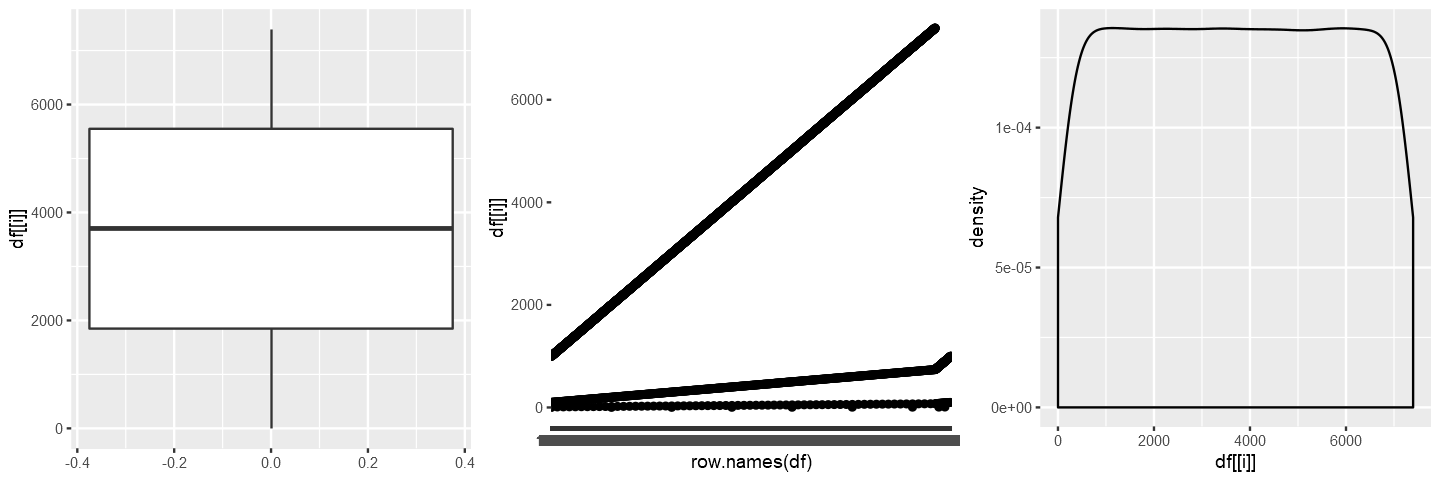

[1] "release_date"


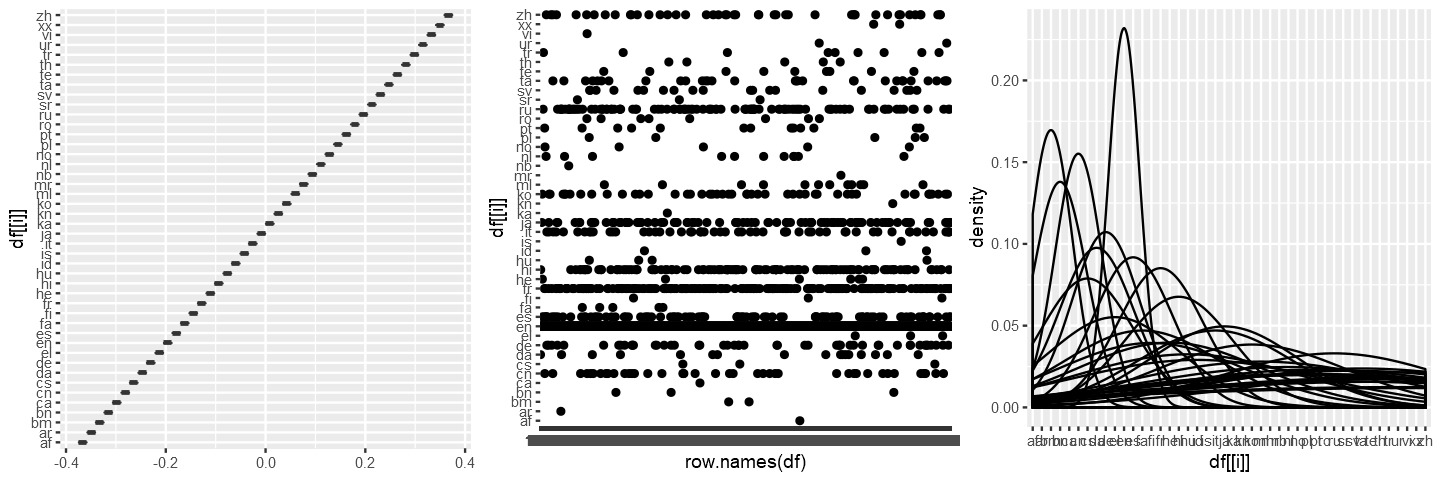

[1] "runtime_cat"


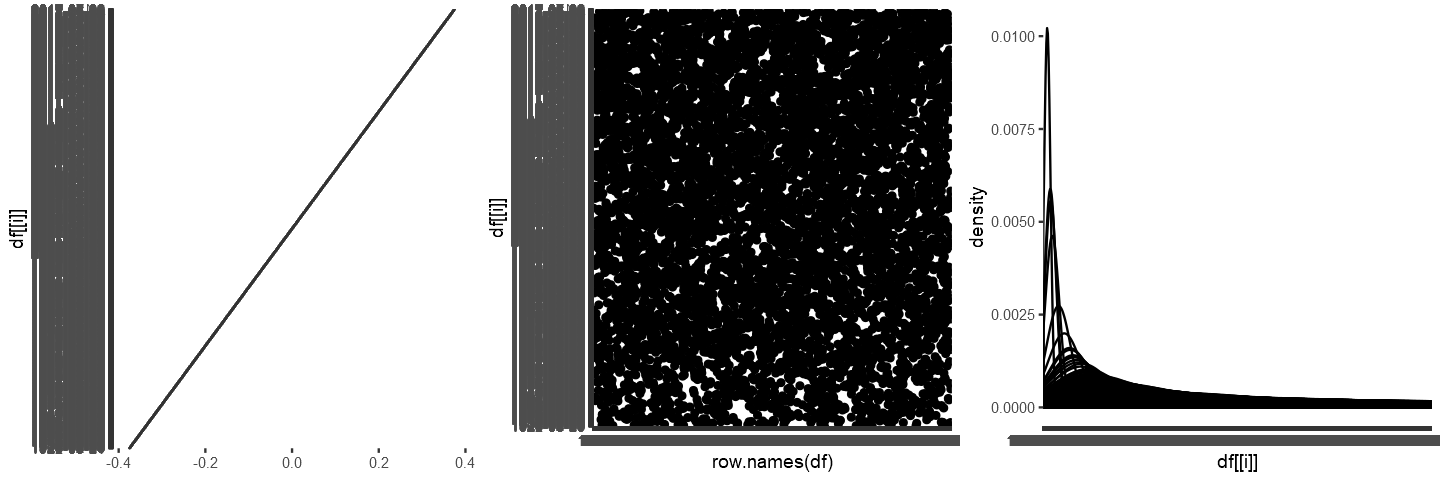

[1] "runtime"


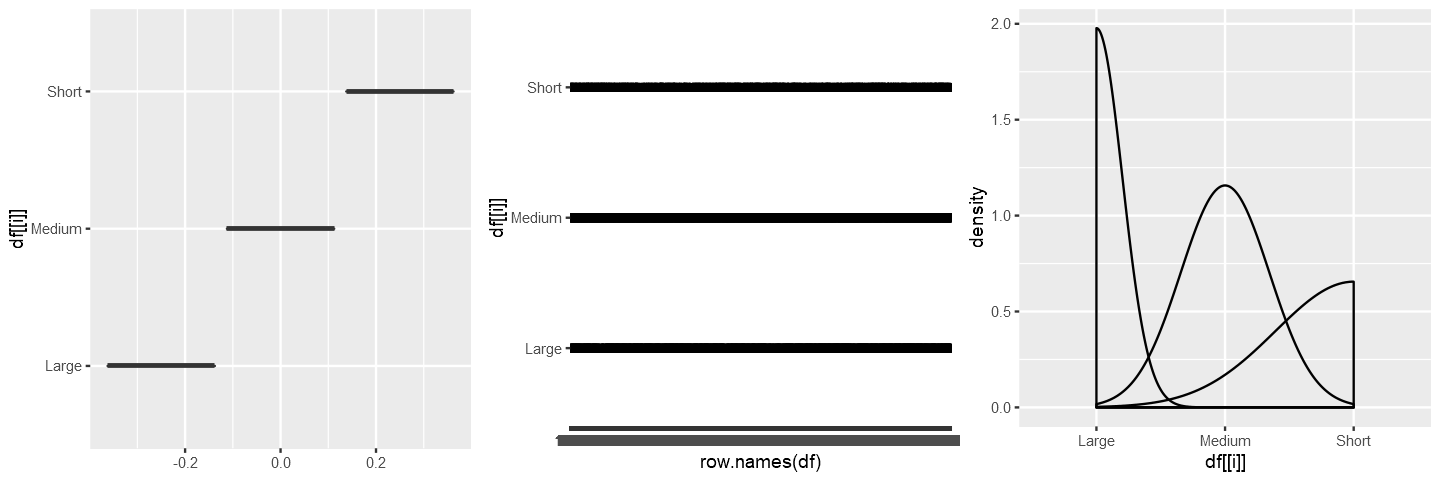

[1] "budget"


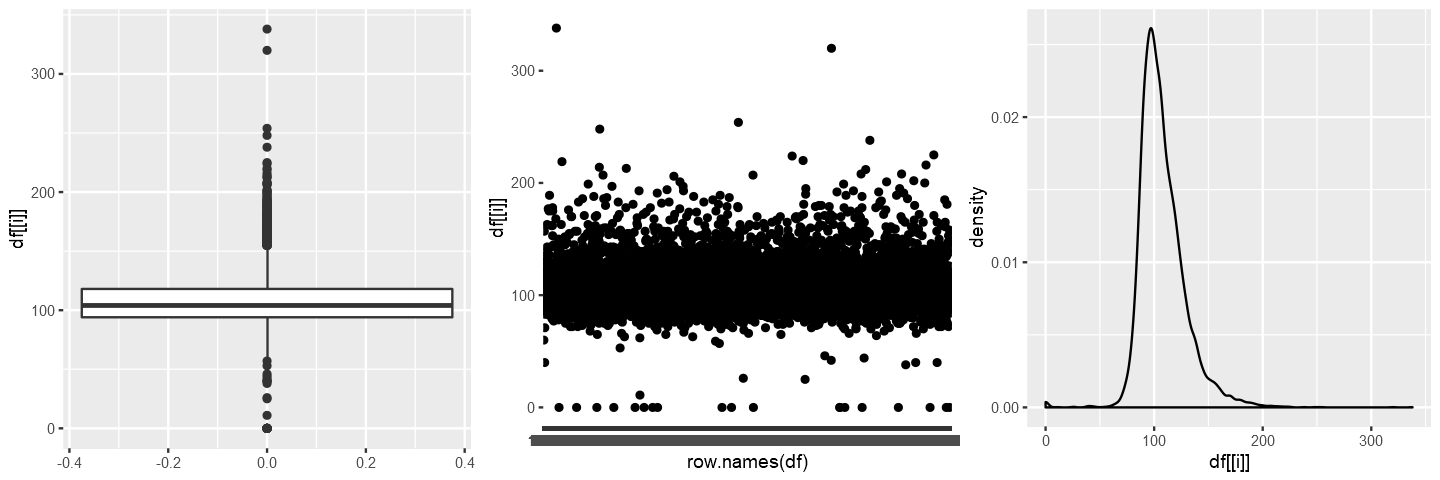

[1] "popularity"


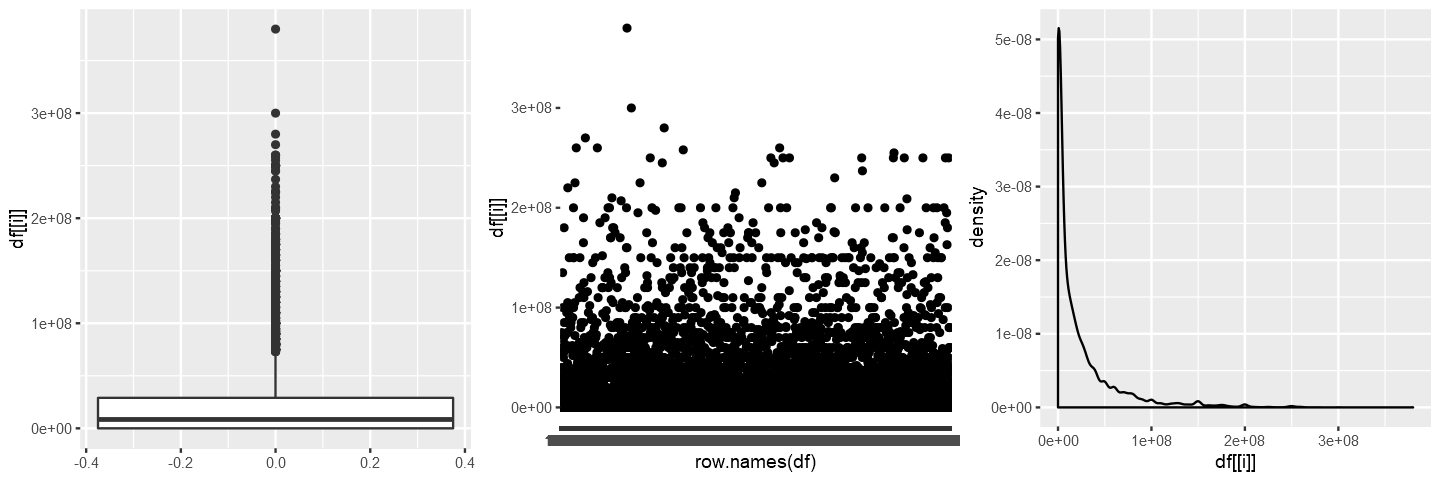

[1] "revenue"


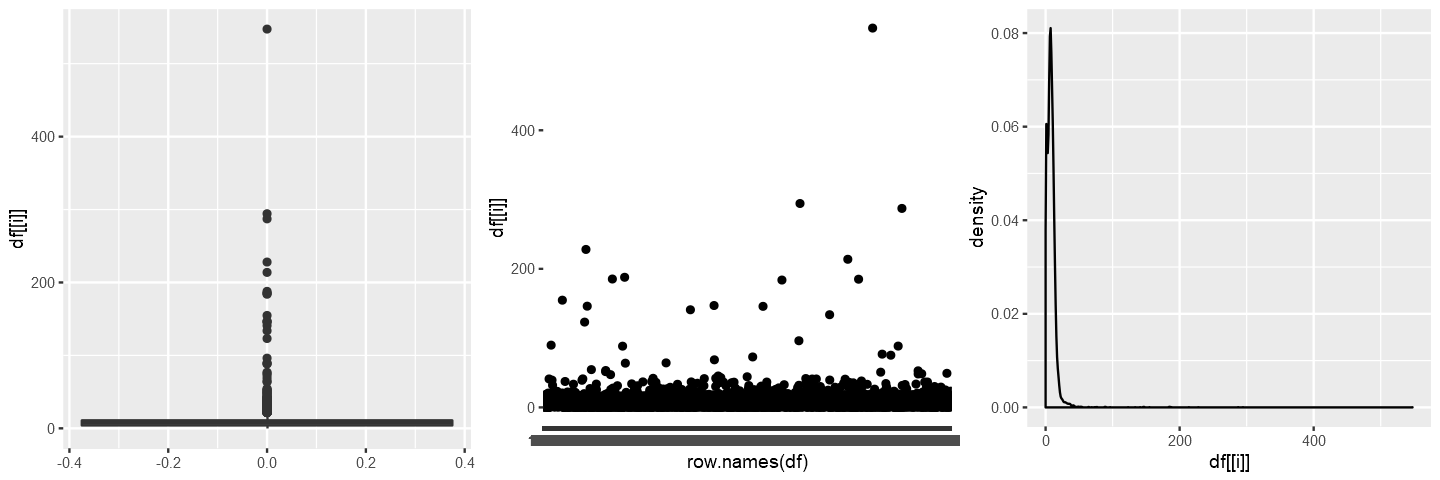

[1] "sw_lang_en"


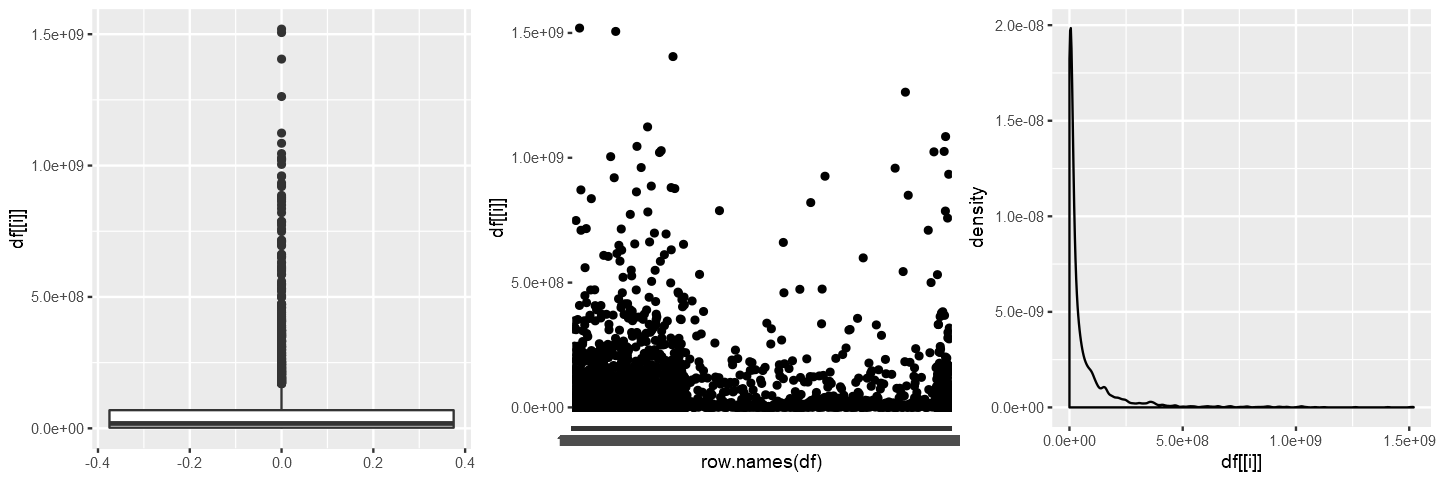

[1] "sw_web_presence"


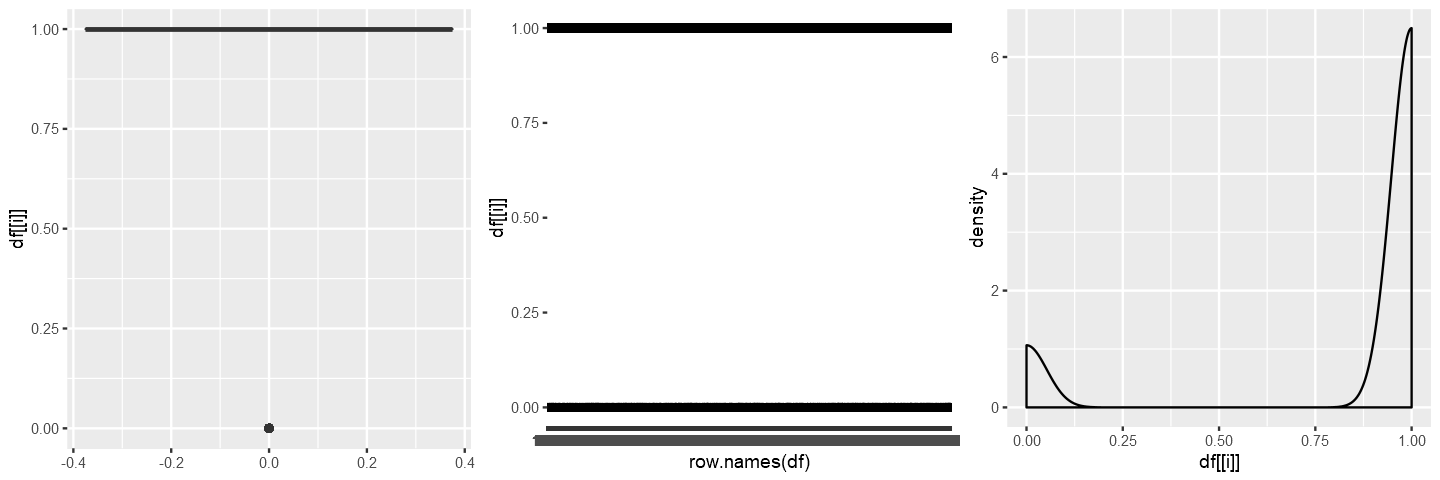

[1] "sw_has_poster"


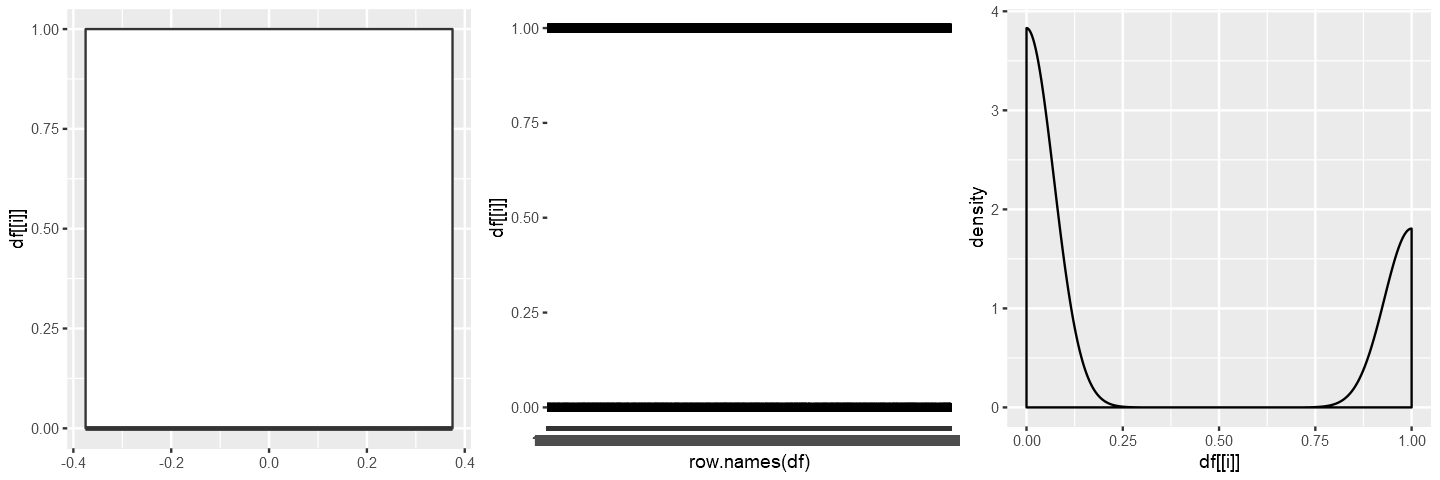

[1] "sw_tagline"


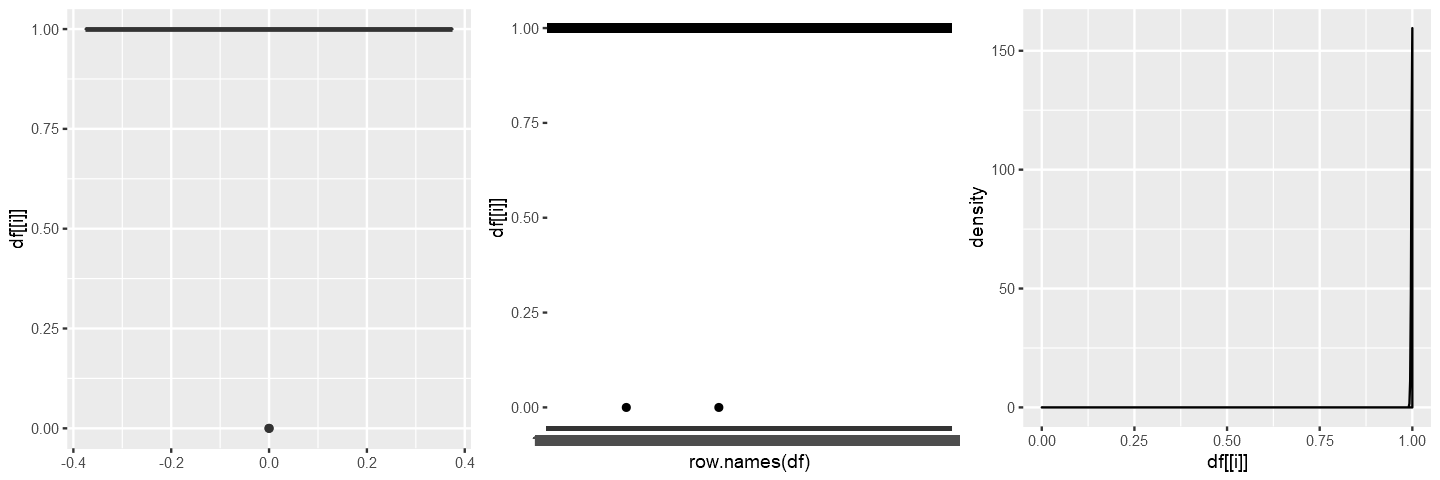

[1] "release_year"


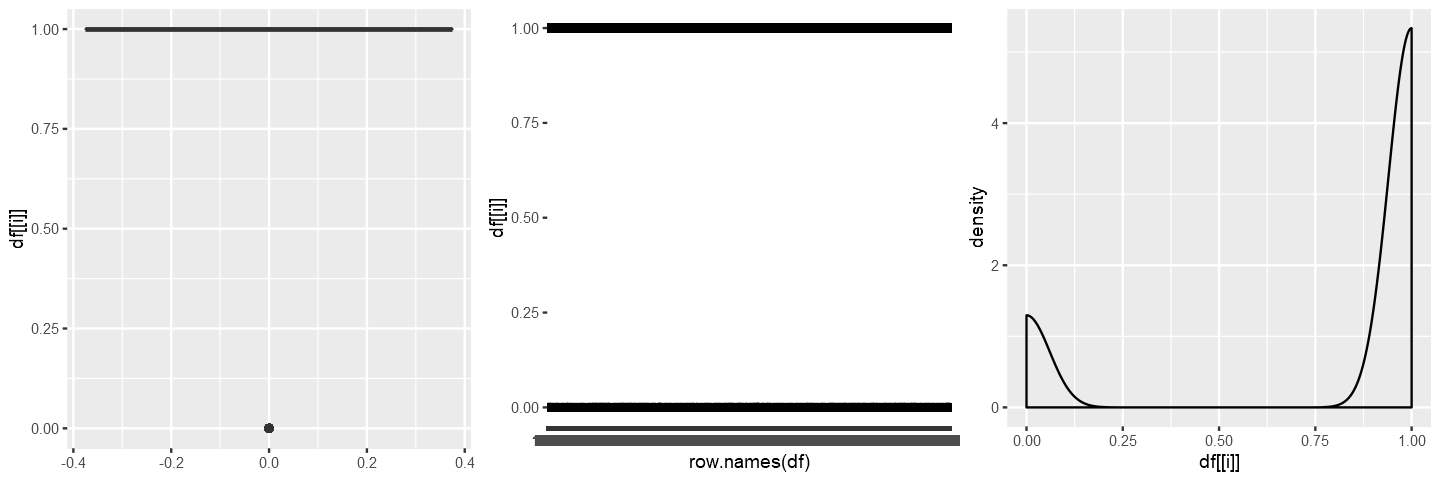

[1] "release_month"


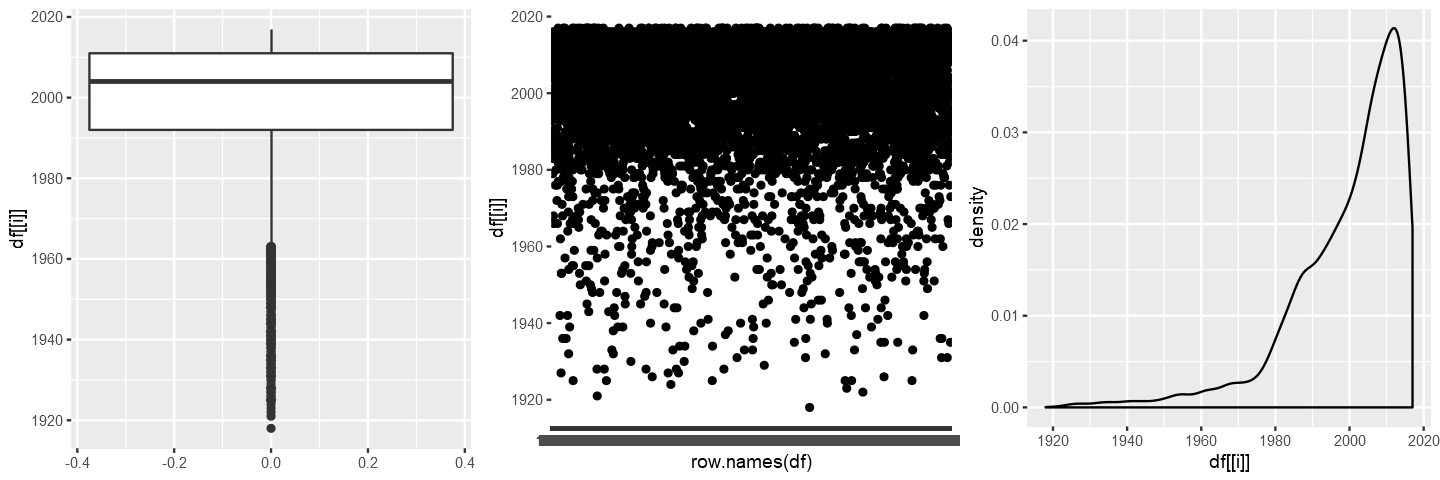

[1] "high_release_month"


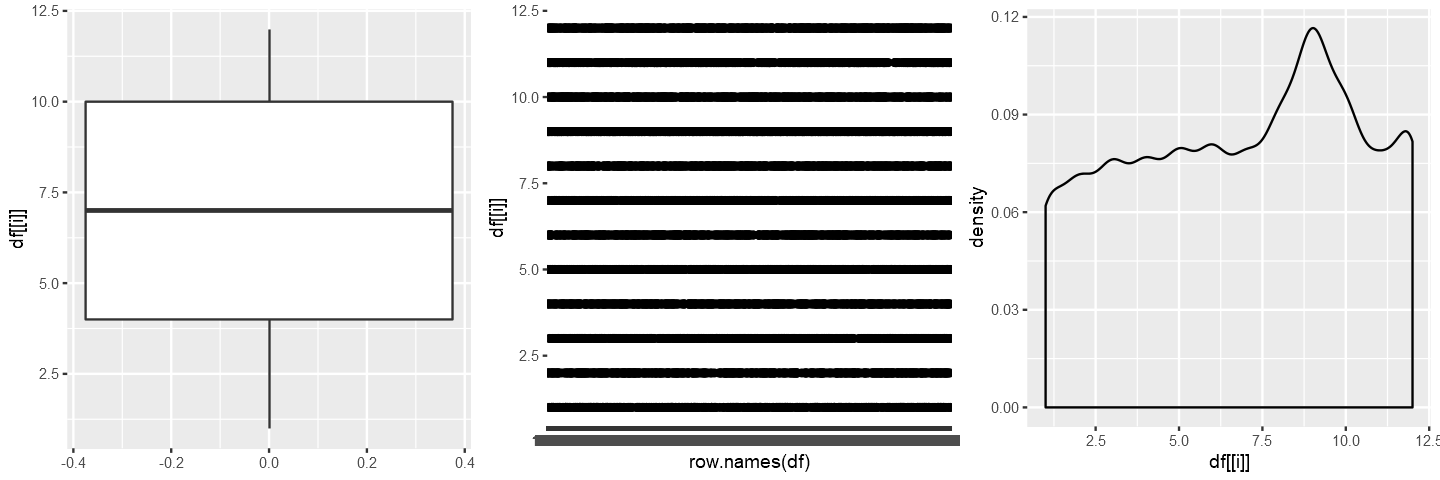

[1] "release_day"


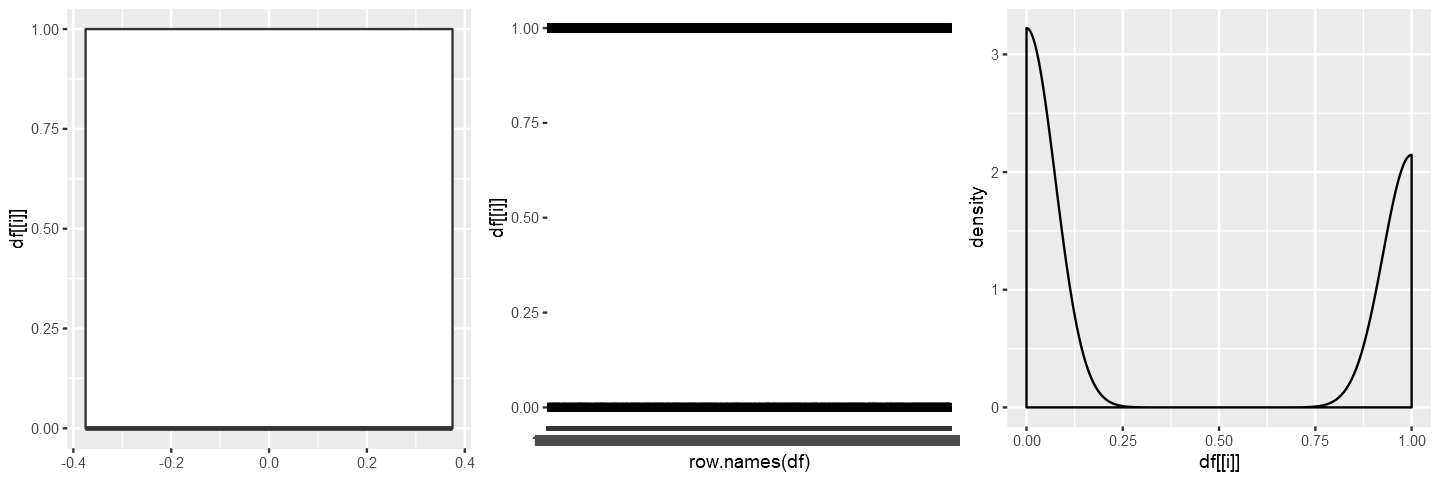

[1] "seasonality"


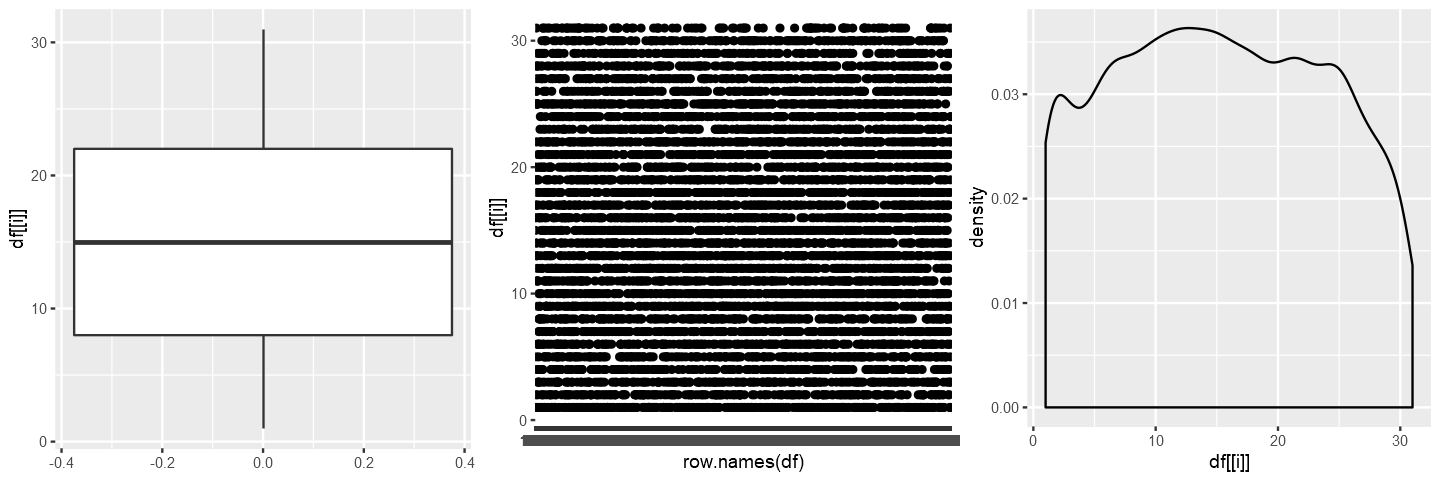

[1] "sw_collection"


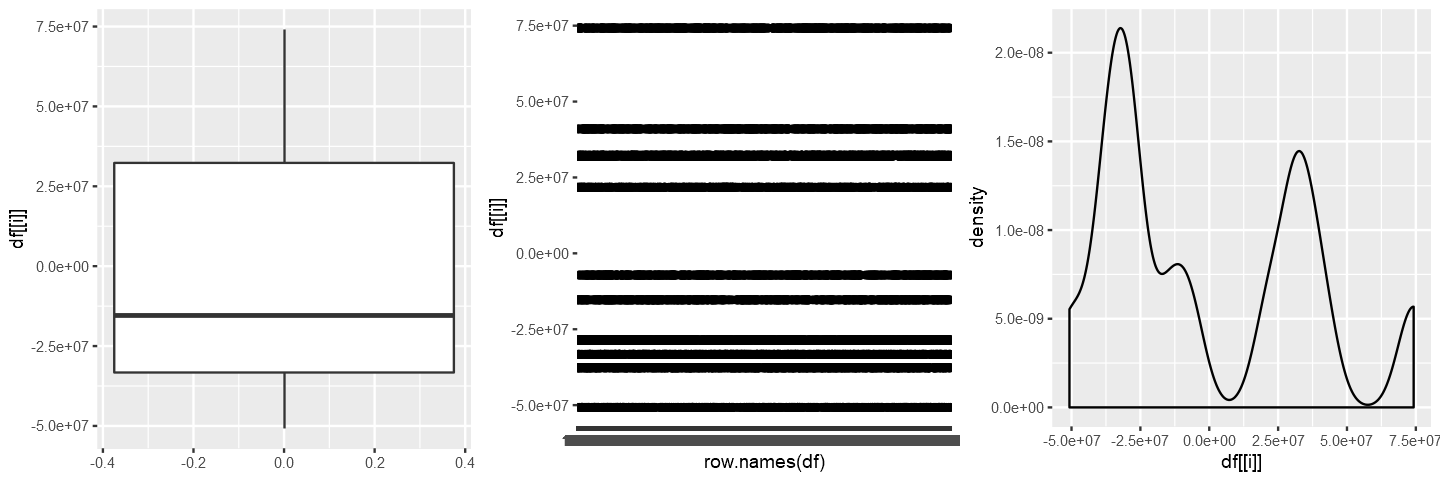

[1] "producers_cnt"


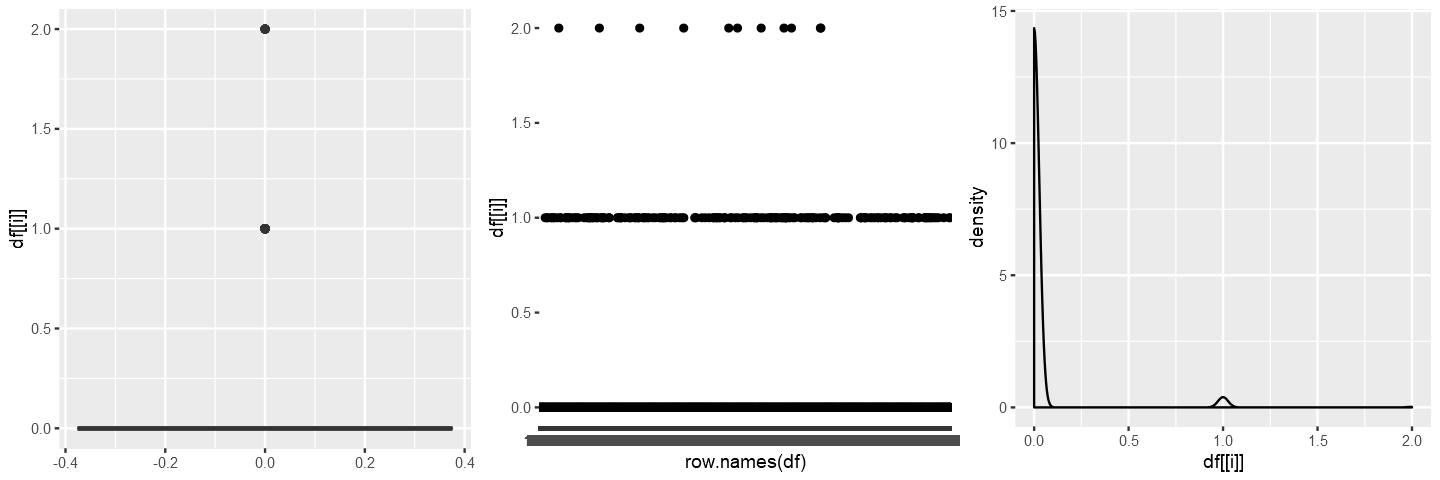

[1] "countries_cnt"


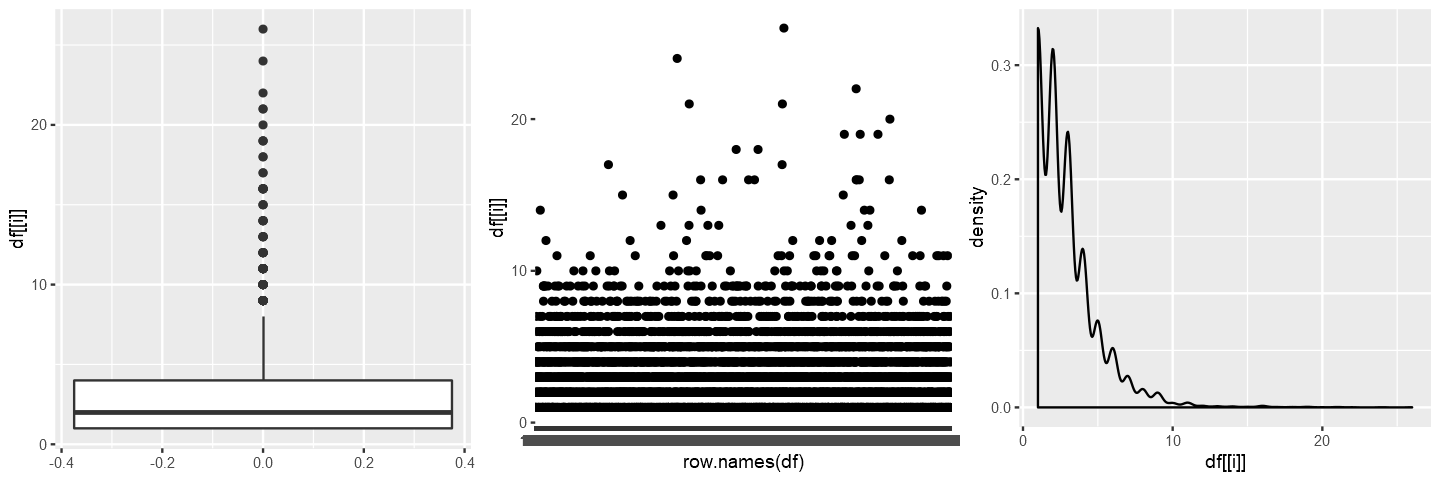

[1] "lang_US"


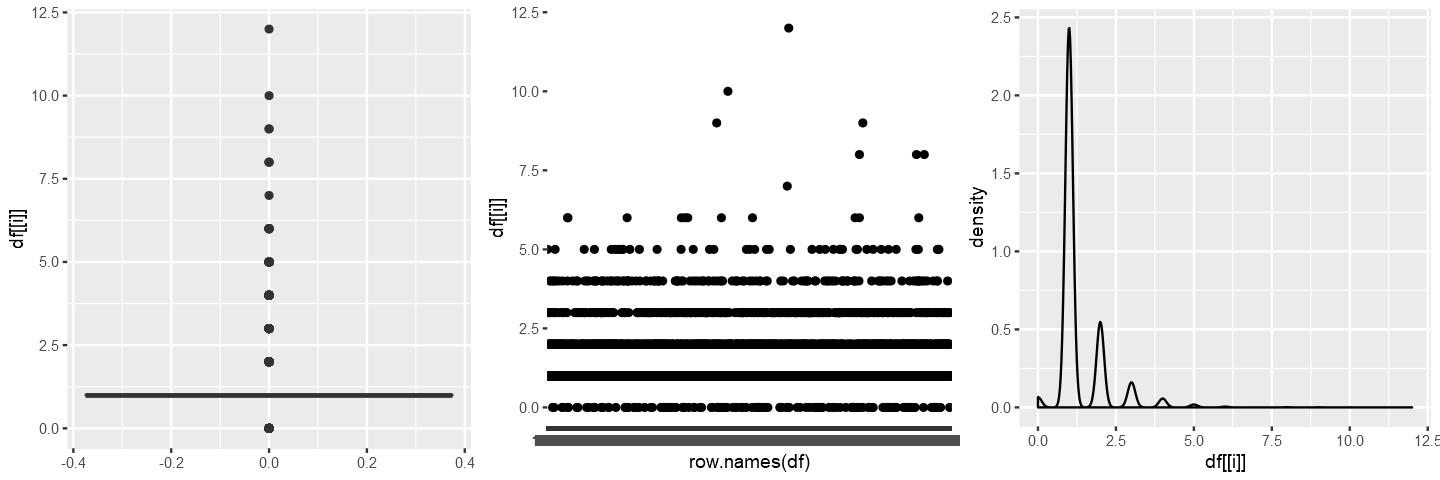

[1] "lang_FR"


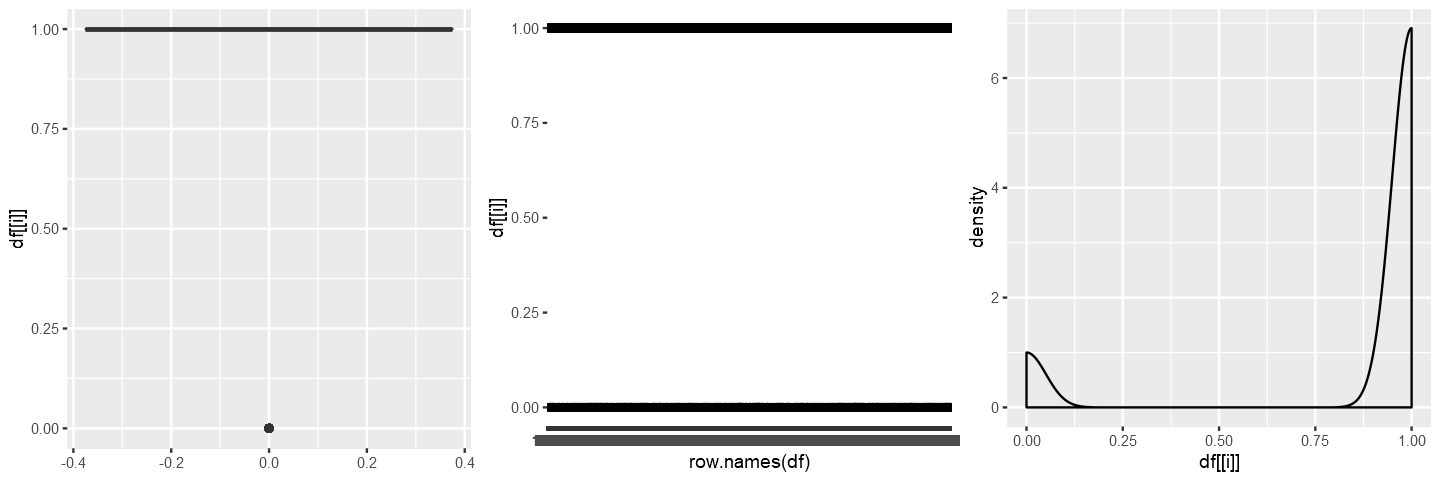

[1] "lang_RU"


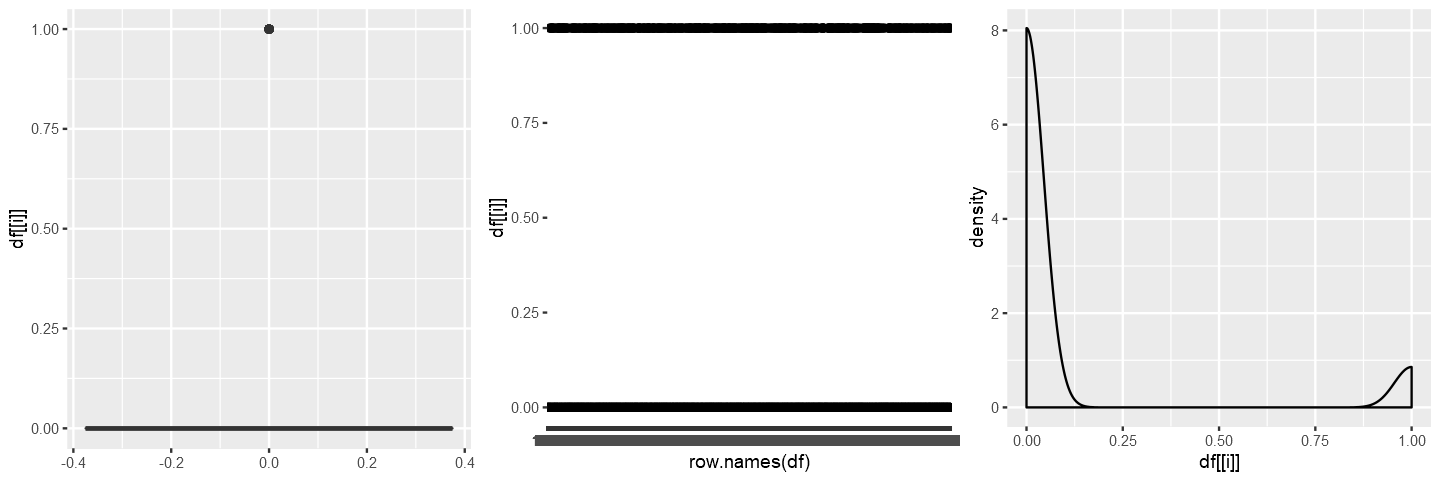

[1] "lang_ES"


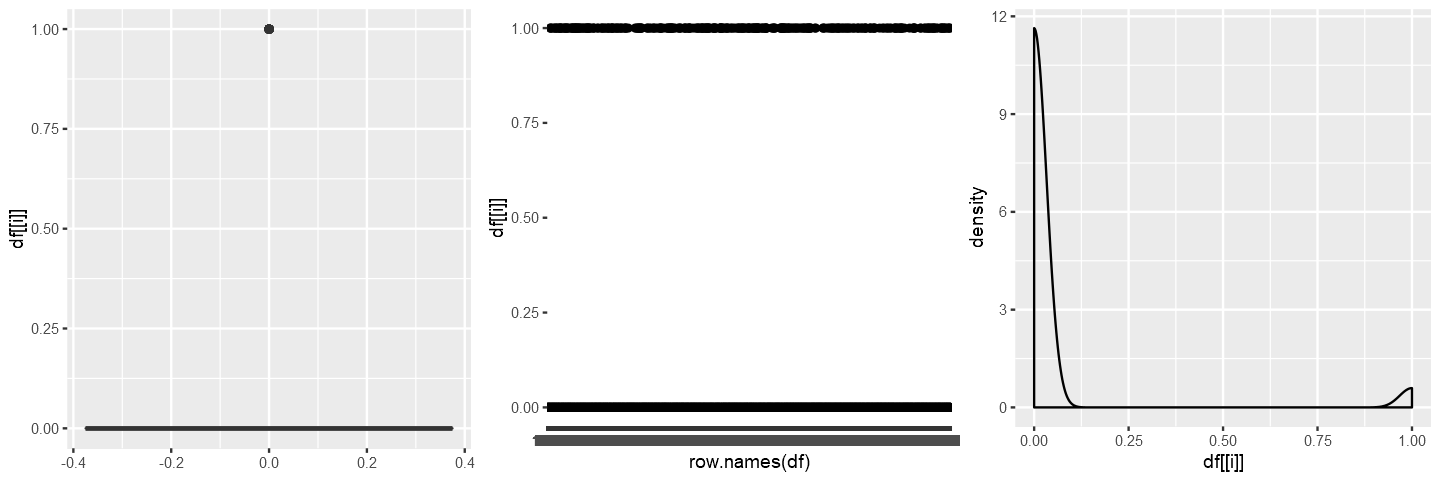

[1] "lang_JA"


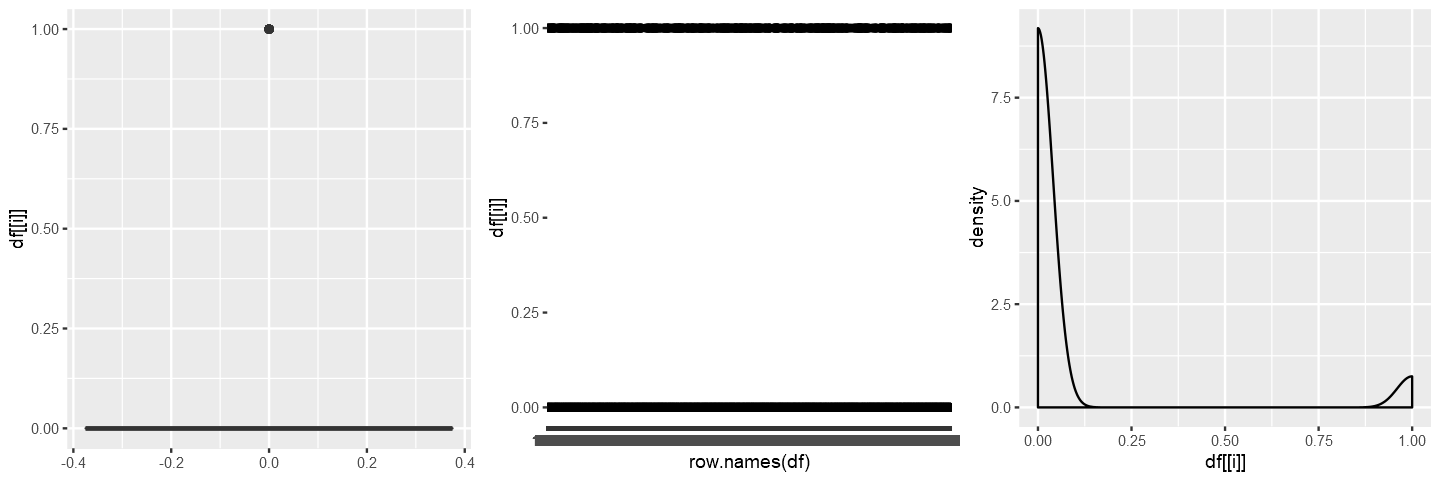

[1] "keywords_cnt"


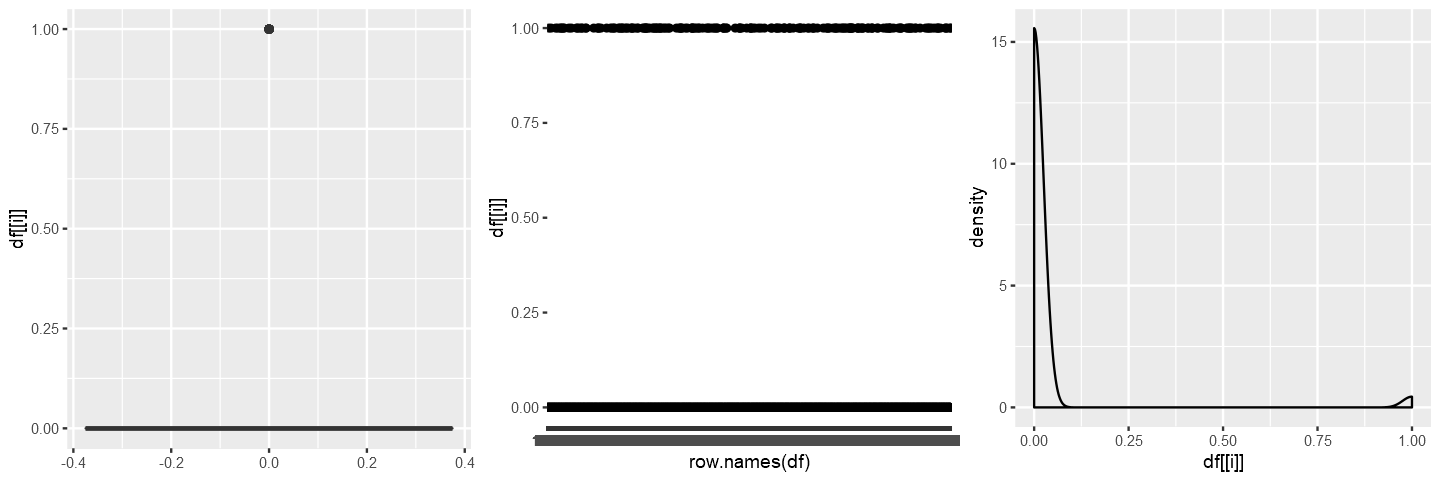

[1] "actor0_movies_cnt"


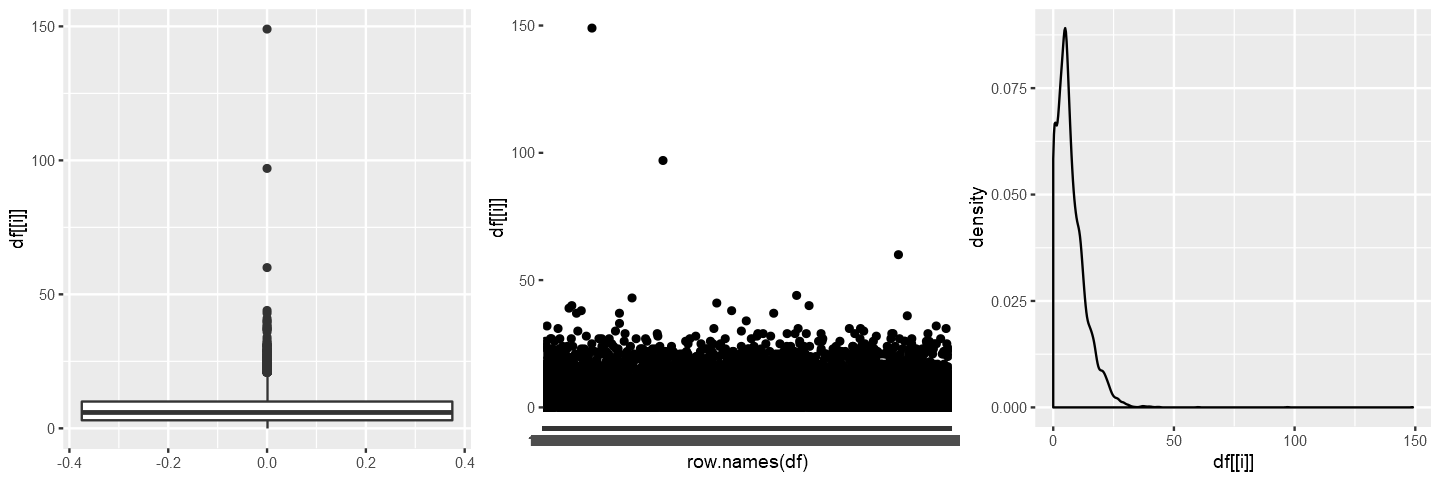

[1] "actor0_movies_5y_cnt"


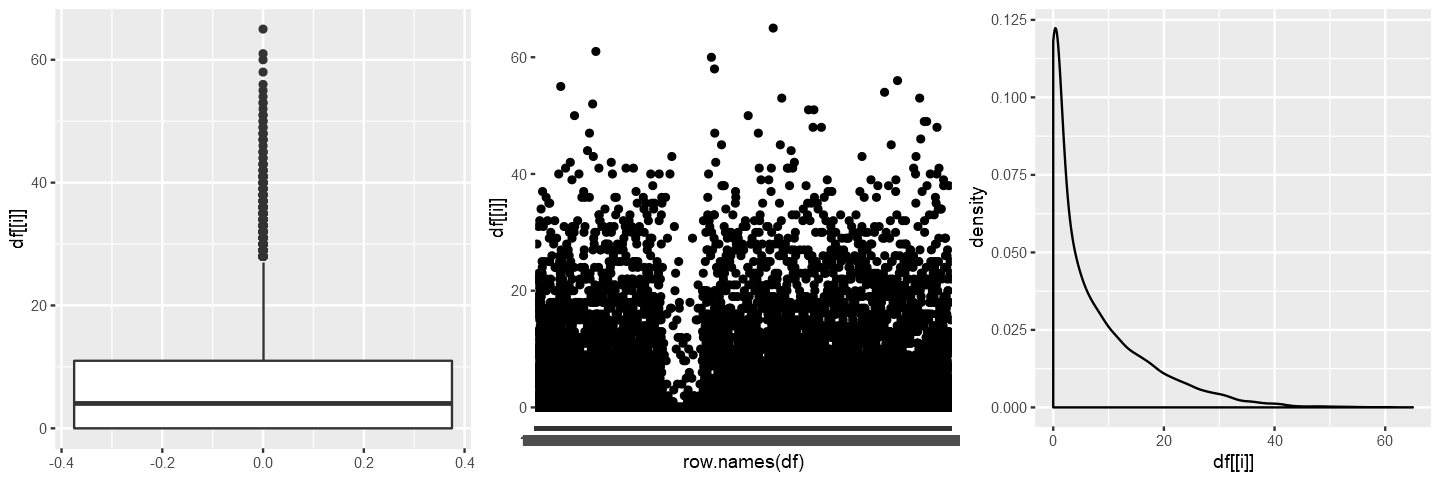

[1] "actor1_movies_cnt"


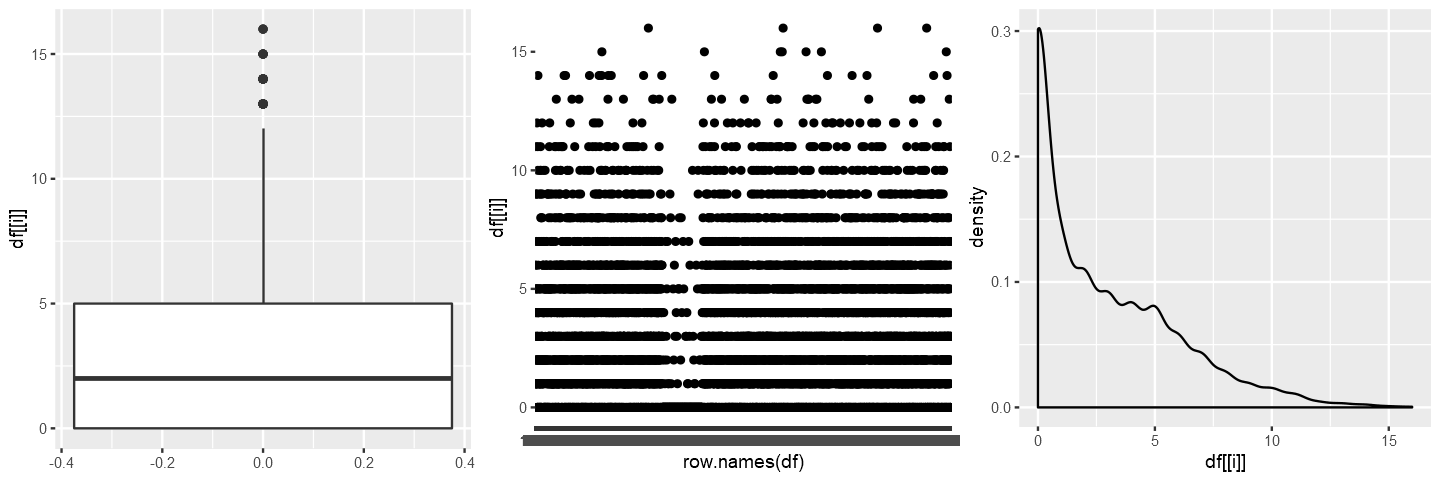

[1] "actor1_movies_5y_cnt"


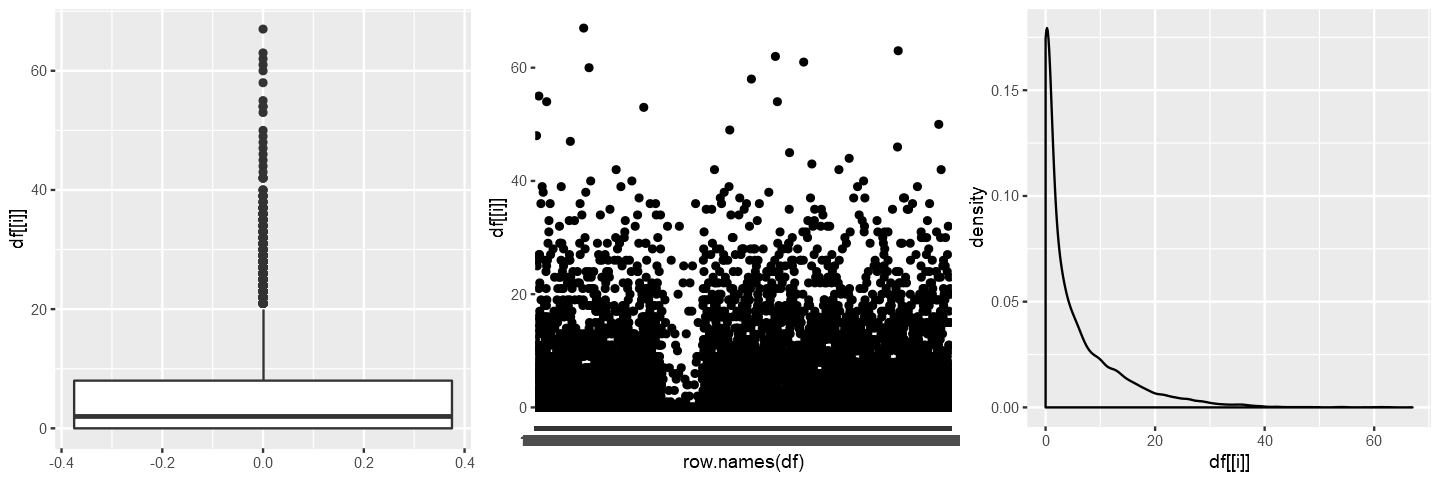

[1] "actor2_movies_cnt"


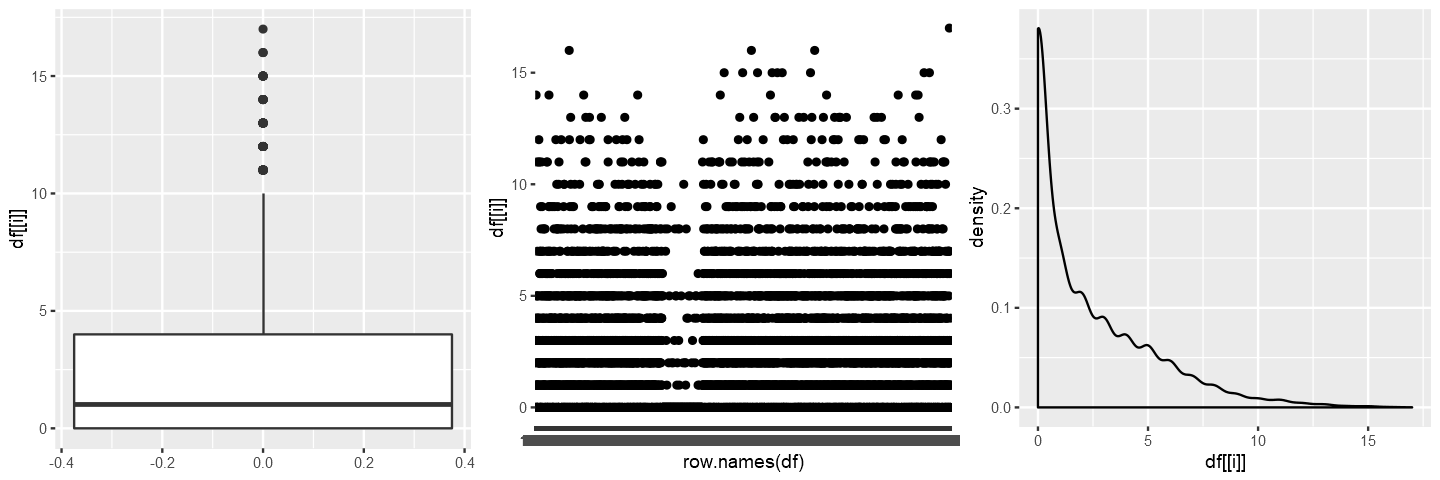

[1] "actor2_movies_5y_cnt"


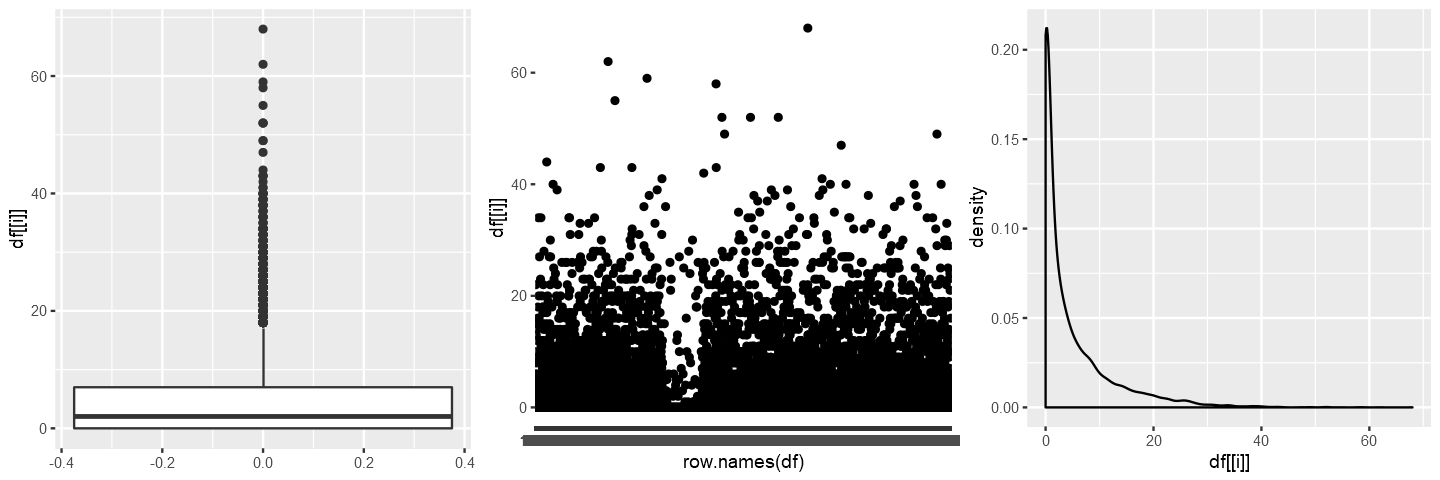

[1] "sw_female_actor0"


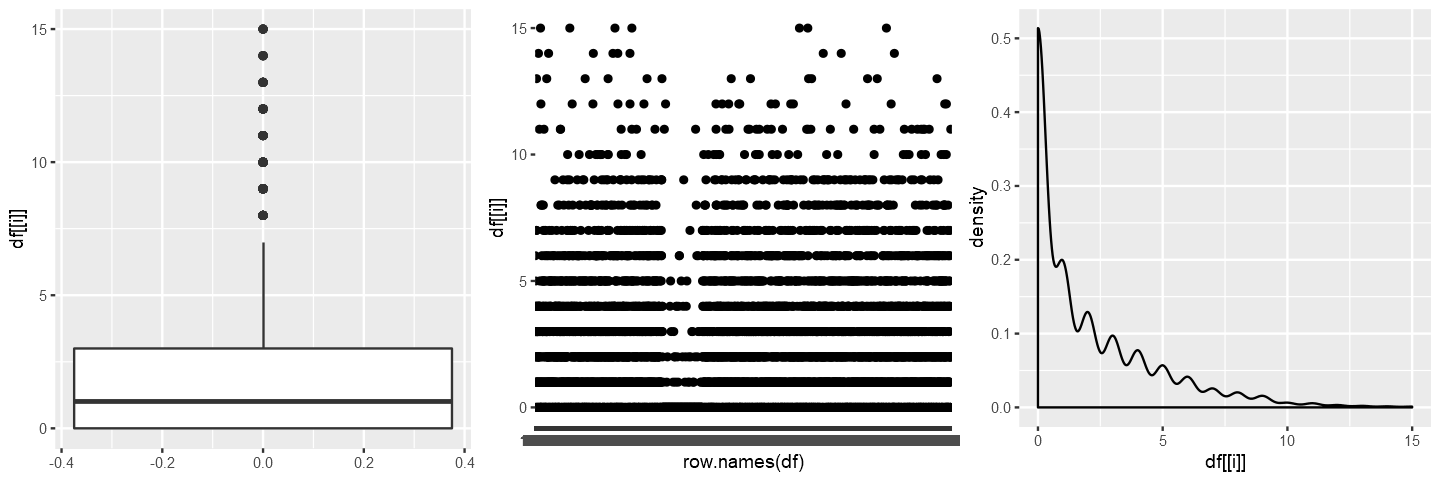

[1] "sw_female_actor1"


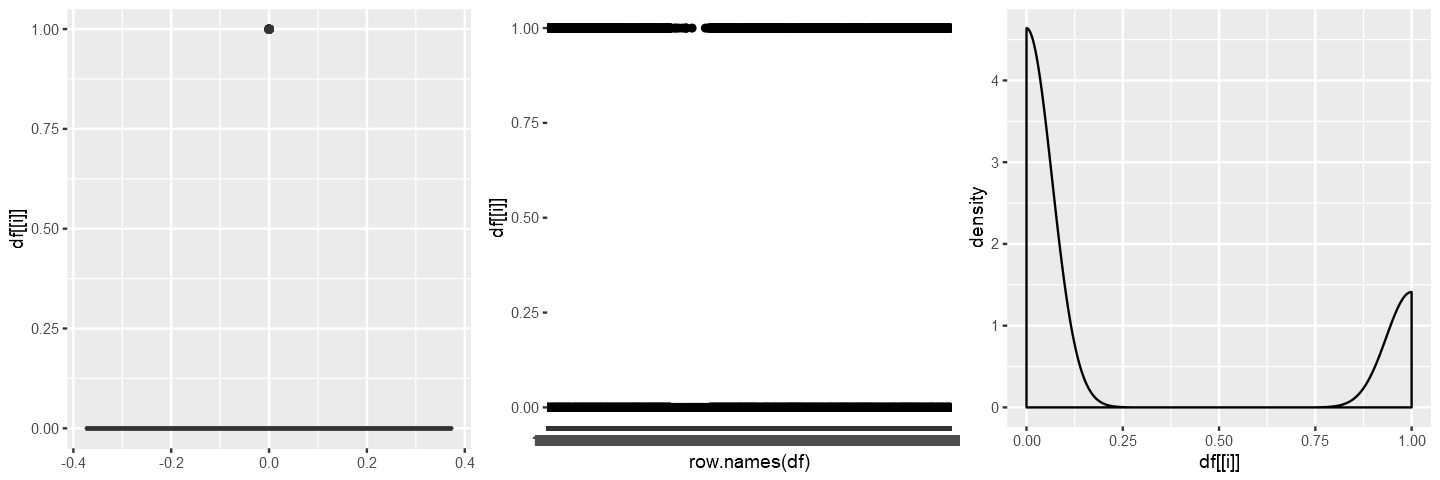

[1] "sw_female_actor2"


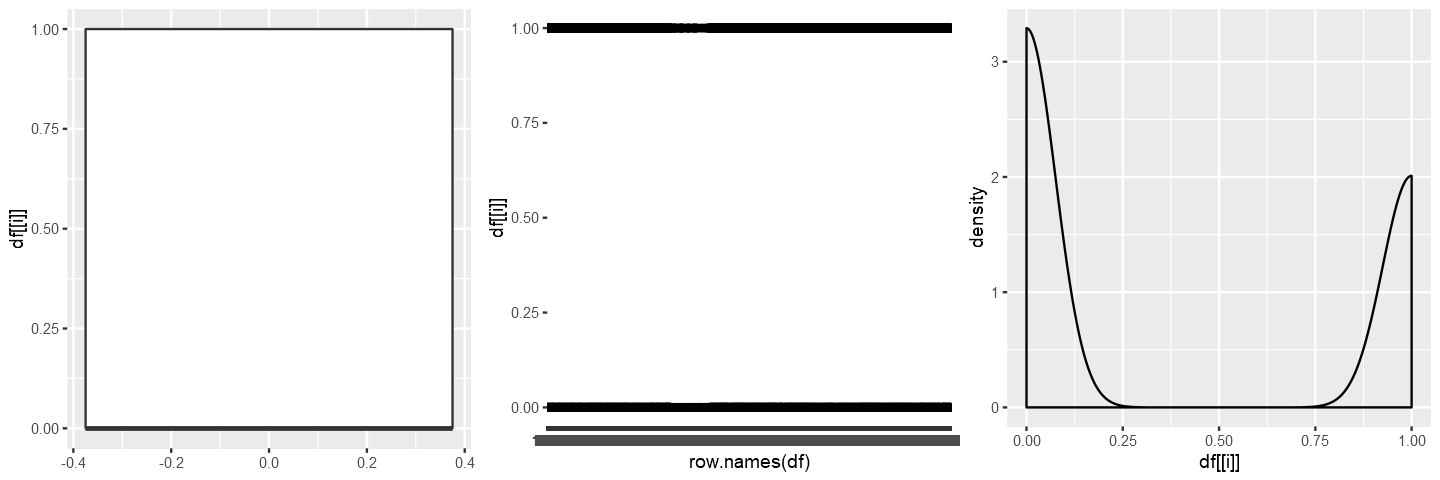

[1] "sw_male_actor0"


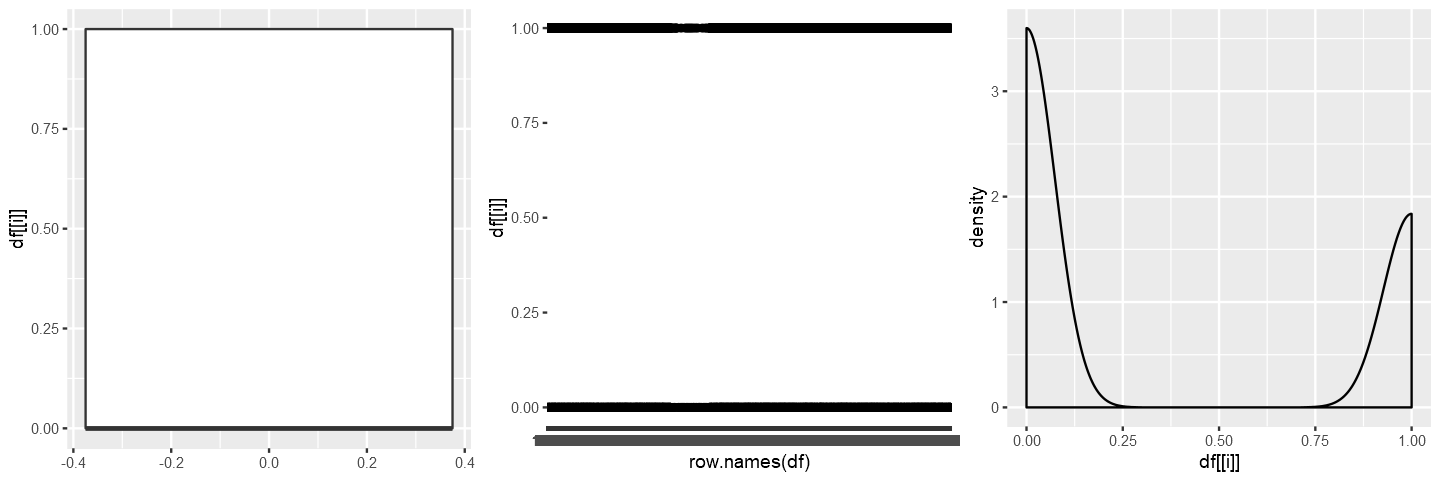

[1] "sw_male_actor1"


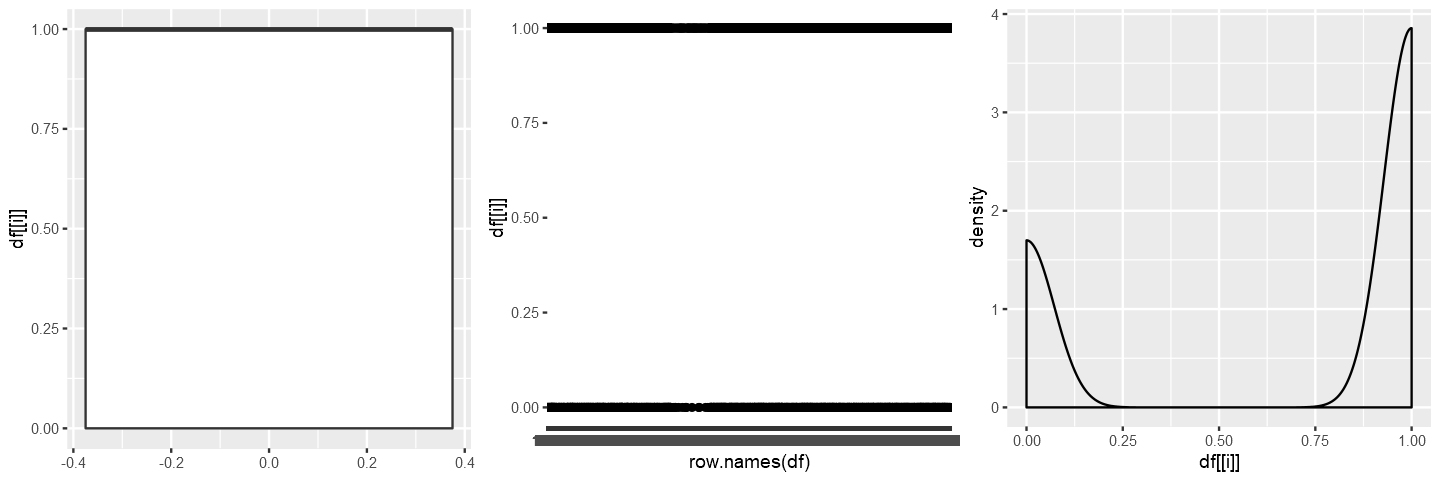

[1] "sw_male_actor2"


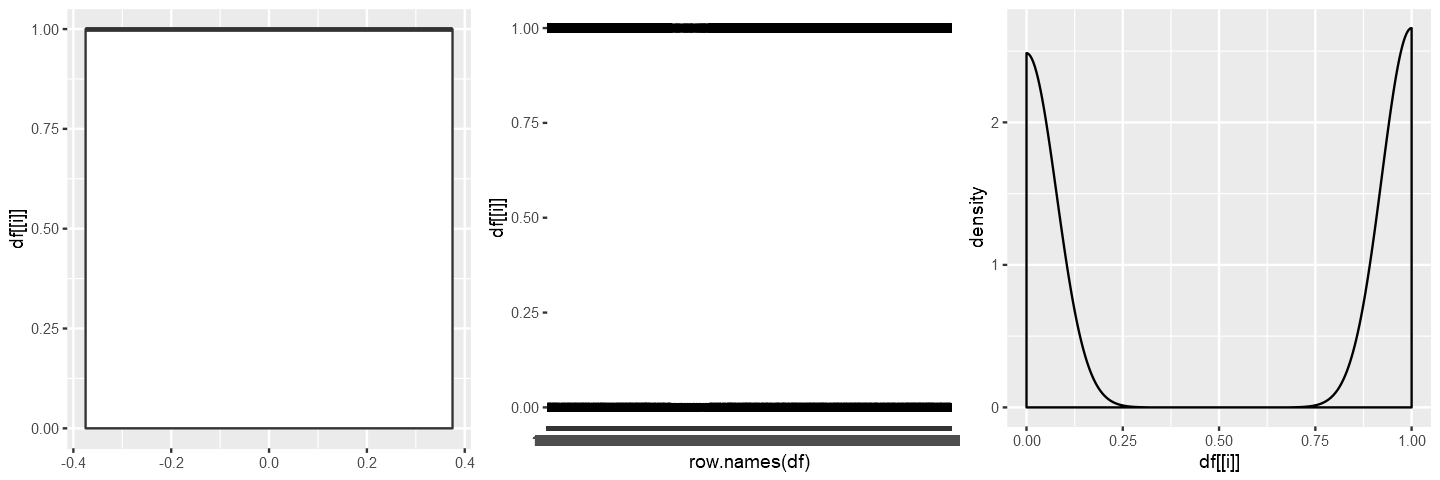

[1] "actor0_prev_revenue"


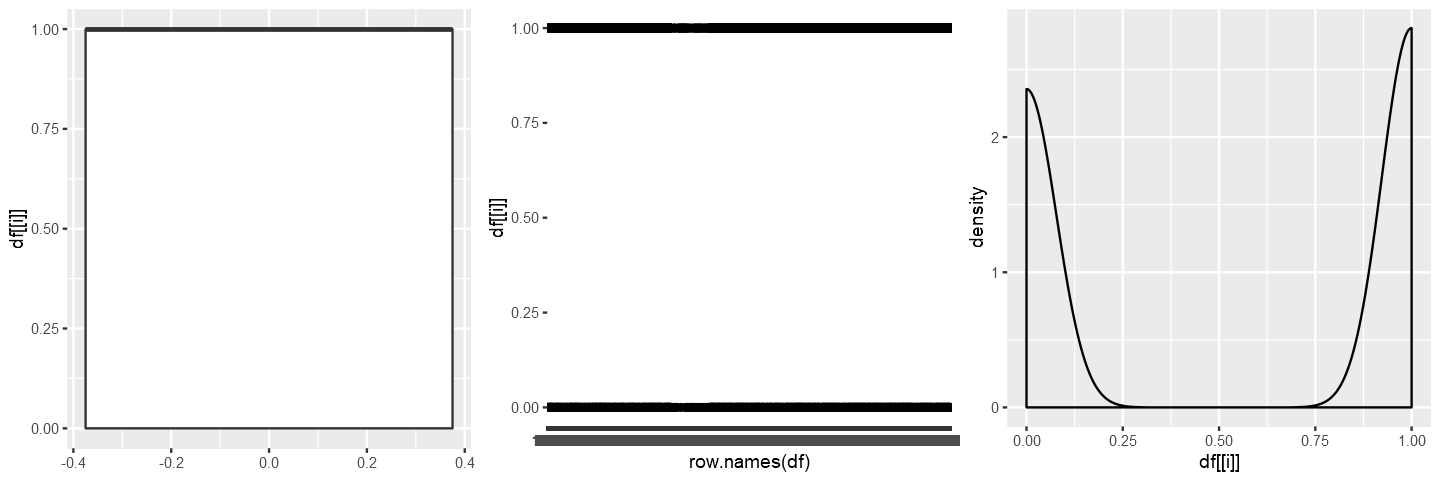

[1] "actor1_prev_revenue"


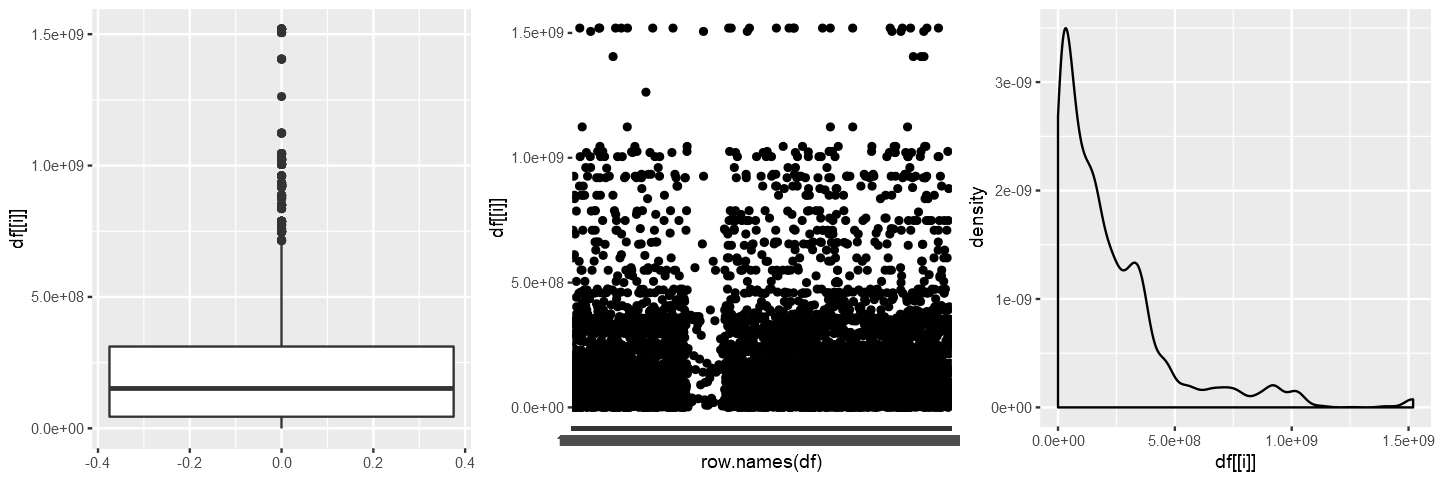

[1] "actor2_prev_revenue"


In [ ]:
options(repr.plot.width = 12, repr.plot.height = 4)
for(i in names(df)) {
    print(i)
    p1 <- ggplot(data=df) + geom_boxplot(aes(y=df[[i]]))
    p2 <- ggplot(data=df) + geom_point(aes(x=row.names(df),y=df[[i]]))
    p3 <- ggplot(data=df) + geom_density(aes(df[[i]]))
    grid.arrange(p1, p2,p3, nrow = 1)
}

In [9]:
str(df$popularity)

 num [1:7375] 6.58 8.25 64.3 3.17 1.15 ...


In [7]:
exploreData <- function(data=data, y=NULL, rn=NULL, factorSize=10, dir="report", debug=FALSE, ...) {

  get_computer_type <- function(){
    # check if current R client is running on PC or on the server
    if (Sys.info()[1] == "Windows") {
      computer.type = "pc"
    } else if (Sys.info()[1] == "Linux") {
      computer.type = "server"
    }
    return(computer.type)
  }

  whatVarType <- function(var) {
    suppressWarnings(if (var=="integer" | var=="numeric") {
      return(1)
    } else if (var=="factor" | var=="character") {
      return(2)
    } else if (var=="Date" | "POSIXct" %in% var[[1]]) {
      return(3)
    } else {
      return(0)
    })
  }

  drawHistogram <- function(imgname=imgname, x=x) {
    d=stats::density(x, kernel = "gaussian",na.rm=TRUE)
    breakstar=(max(x,na.rm=TRUE) -min(x,na.rm=TRUE))/d$bw
    h=graphics::hist(x, breaks=breakstar)
    graphics::plot(h,main="",xlab=imgname)
    yfit<-seq(min(x,na.rm=TRUE),max(x,na.rm=TRUE),length=40)
    ffit<-stats::dnorm(yfit,mean=mean(x,na.rm=T),sd=stats::sd(x,na.rm=T))
    ffit <- ffit*diff(h$mids[1:2])*length(x)
    lines(yfit, ffit, col="blue", lwd=2)
  }

  drawFakeGraph <- function(imgname=imgname) {
    graphics::plot.window(xlim = c(0,0),ylim = c(0,0))
  }

  drawBars <- function(imgname=imgname, x=x) {
    graphics::plot(x)
  }

  drawGraphOne <- function(imgname=imgname, numVar=x, vartype=1) {
    if(vartype==1) {
      drawHistogram(imgname,numVar)
    } else if(vartype==2) {
      drawBars(imgname,numVar)
    } else {
      drawFakeGraph(imgname)
    }
  }

  getContinuousStats <- function(x) {
    N <- length(x)
    n <- length(x[which(is.na(x)==FALSE)])
    pct <- formatC(n/N * 100)
    nmiss <- length(x[which(is.na(x)==TRUE)])
    npct <- formatC(nmiss/N *100)
    ma <- mean(x, na.rm=TRUE)
    s <- stats::sd(x, na.rm=TRUE)
    me <- formatC(stats::median(x, na.rm=TRUE))
    q1 <- formatC(stats::quantile(x,1/4, na.rm=TRUE))
    q3 <- formatC(stats::quantile(x,3/4, na.rm=TRUE))
    mn <- formatC(min(x, na.rm=TRUE))
    mx <- formatC(max(x, na.rm=TRUE))
    html <- paste("<div class='Cell' style='align: top;'> <u>Data type</u>: Continuous <p> <u>Data length</u>: ",n ,"/", N, " (", pct, "%) <br> <u>Missing</u>: ",
                  nmiss, " (", npct, "%)<p> <u>Mean</u>: ", formatC(ma), "\t <u>StdDev</u>: ", formatC(s), "<br><u>Median</u>: ",me,
                  "\t <u>IQR</u>: ", q1, "-", q3, "<br><u>Min</u>: ", mn, "\t <u>Max</u>: ", mx, "</div>")
    return(html)
  }

  getCategortyStats <- function(x) {
    N <- length(x)
    n <- length(x[which(is.na(x)==FALSE)])
    pct <- formatC(n/N * 100)
    nmiss <- length(x[which(is.na(x)==TRUE)])
    npct <- formatC(nmiss/N *100)
    l <- levels(x)
    s <- summary(x)
    htm <- "<ul>"
    if (length(l) < 5) {
      for (lv in l) {
        htm <- paste(htm, "<li><u>", lv, "</u>: ", s[[lv]], "</li>")
      }
      htm <- paste(htm,"</ul>")
    }
    html <- paste("<div class='Cell'> <u>Data type</u>: Categorical Data <p> <u>Data length</u>: ",n, "/", N, " (", pct, "%) <br> <u>Missing</u>: ",
                  nmiss, " (", npct, "%) <p> <u>Number of levels</u>: ", length(l), "<br>", htm, "</div>")
    return(html)
  }

  getDatesStats <- function(x) {
    N <- length(x)
    n <- length(x[which(is.na(x)==FALSE)])
    pct <- formatC(n/N * 100)
    nmiss <- length(x[which(is.na(x)==TRUE)])
    npct <- formatC(nmiss/N *100)
    s <- summary(x)
    html <- paste("<div class='Cell'> <u>Data type</u>: Date <p> <u>Data length</u>: ",n, "/", N, " (", pct, "%) <br> <u>Missing</u>: ",
                  nmiss, " (", npct, "%) <p> <u>Min date</u>: ", min(x, na.rm=T), "<br><u>Max date</u>:",max(x, na.rm=T) , "</div>")
    return(html)
  }

  getStats <- function(numVar=x, vartype=1) {
    if(vartype==1) {
      html <- getContinuousStats(numVar)
    } else if(vartype==2) {
      html <- getCategortyStats(numVar)
    } else if (vartype==3) {
      html <- getDatesStats(numVar)
    } else {
      html <- "<div class='Cell'></div>"
    }
    return(html)
  }

  getOutliers <- function(x) {
    bp <- graphics::boxplot(x,plot=FALSE)
    return(bp$out)
  }

  getOutlierGraph <- function(x) {
    #  mod <- tryCatch({
    outl <- getOutliers(x)
    df <- data.frame(x=x, cl=1)
    if(length(outl)>0) {
      df$cl[which(df$x %in% outl)] <- 2
    }
    #pl <- stats::scatter.smooth(df$x,col=df$cl)
    pl <- tryCatch({
      stats::scatter.smooth(df$x,col=df$cl,xlab="index")
    }, warning = function(w) {
      n <- "warning!"
    }, error = function(e) {
      n <- "error!"
    }, finally = {
      graphics::plot(df$x ~ row.names(df),col=df$cl,xlab="index")
    })
    ma <- mean(x, na.rm=TRUE)
    s <- stats::sd(x, na.rm=TRUE)
    graphics::abline(h=ma-(2*s), col="red", lty=2)
    graphics::abline(h=ma+(2*s), col="red", lty=2)
    #  }, error = function(e) {
    #    pl <- drawFakeGraph("none")
    #  })
    return(pl)
  }

  getScatterGraph <- function(df=data,x,y,dtype=1) {
    #  mod <- tryCatch({
    if(dtype==1) {
      pl <- ggplot2::ggplot(df) + ggplot2::geom_smooth(ggplot2::aes(x=data[[x]], y=data[[y]]), method="loess") + ggplot2::xlab(x) + ggplot2::ylab(y)
    } else {
      pl <- ggplot2::ggplot(df) + ggplot2::geom_boxplot(ggplot2::aes(y=data[[x]], color=data[[y]])) + ggplot2::xlab(x) + ggplot2::ylab(y) + ggplot2::labs(color=y)
    }
    return(pl)
  }

  getOutliersHtml <- function(imgname=imgname, x=x, srcdir=srcdir) {
    bp <- getOutliers(x)
    if (length(unique(bp)) > 10) {
      xtrm <- paste("There are ", length(unique(bp)), " outlier values")
    } else if (length(unique(bp)) == 0) {
      xtrm <- "No outlier values found"
    } else {
      xtrm <- paste(formatC(unique(bp)), collapse=', ' )
    }
    imgsrc = paste(paste0(srcdir,"/fig/"),imgname, "_2.png",sep="")
    html <- paste0("<div class='Cell'><img class='origimg' src='",imgsrc,"' height='150' width='250'><br> <u>Outlier values</u>: <br> ", xtrm, "</div>")
    return(html)
  }
  ################## Prepare for the report ###################
  #report <- paste(mydir,"/report",sep="")

  ################## Check for values for rn ##################
  if(!is.null(rn)) {
    if(length(rn)!=ncol(data)) {
      message("the value of the 'rn' argument was avoided because it does not have the same number of columns of the dataframe")
      rn <- NULL
    }
    xname <- rn
    names(xname) <- names(data)
  } else {
    xname <- NULL
  }

  report <- dir
  if (!file.exists(report)) {
    dir.create(report)
  }
  fig <- paste(report,"/fig",sep="")
  if (!file.exists(fig)) {
    dir.create(fig)
  }
  if (get_computer_type()=="pc") {
    srcdir <- paste0(getwd(),"/",report)
  } else {
    #srcdir <- paste0("file_show?path=",getwd(),"/",report)
    srcdir <- paste0("/view/",getwd(),"/report")
  }
  # determine which columns are integer
  int_col <- which(sapply(data, is.integer))
  int_col <- c(int_col,(which(sapply(data, is.numeric))))
  mi <- vector()
  # find only those integers with less than 10 unique values and convert to factor
  for (li in int_col) {
    if (length(unique(data[,li])) < factorSize) {
      mi <- c(mi,li)
      if (is.factor(data[,li]) == FALSE) {
        data[,li] <- factor(data[,li])
      }
    }
  }

  str_col <- which(sapply(data, is.character))
  mi <- vector()
  # find only those integers with less than 10 unique values and convert to factor
  for (li in str_col) {
    mi <- c(mi,li)
    data[,li] <- factor(data[,li])
  }

  # create the html report page
  myhtml <- paste(report,"/report.html",sep="")
  cat("<!DOCTYPE html>
      <html>
      <head>
      <title>Data Visualization</title>
      <meta http-equiv='Content-Type' content='text/html; charset=UTF-8' />
      <link rel='stylesheet' href='http://code.jquery.com/mobile/1.4.5/jquery.mobile-1.4.5.min.css'>

      <script src='http://code.jquery.com/jquery-1.10.2.js'></script>
      <script>
      $(document).ready(function(){
      $('.onetoone').hide();
      });

      $(function() {
      $('.origimg').click(function(e) {
      $('#popup_img').attr('src',$(this).attr('src'));
      $('#myContainer').hide();
      var pos = $(document).scrollTop();
      $('#myContainer').css({'top':pos+20,'left':250, 'position':'absolute', 'border':'1px solid black', 'padding':'0px'});
      $('#myContainer').show();
      });
      $('#myContainer').click(function(e) {
      $('#myContainer').hide();
      });

      $('#myform2').submit(function(e) {
      e.preventDefault();
      });

      $('#onetoone').on('click',function() {
      console.log('onetone button - 1');
      $('#onetoone').hide();
      $('#aslist').show();
      // To show only individual rows:
      $('.Row').hide();
      $('.onetoone').show();
      // then we iterate
      var i = $('.Row').length;
      // Then we iterate
      var nxt = $('#idx').val();
      if (nxt < i & nxt >0) {
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(1)
      }
      console.log('onetone button - 2');
      });

      $('#aslist').on('click',function() {
      console.log('aslist button - 1');
      $('#onetoone').show();
      $('#aslist').hide();
      $('.onetoone').hide();
      $('.Row').show();
      console.log('aslist button - 2');
      });

      $('#less').on('click',function(){
      console.log('less button - 1');
      var i = $('.Row').length;
      var nxt = parseInt($('#idx').val(),10) - 1;
      if (nxt < i & nxt >0) {
      $('#idx').val(nxt)
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(1)
      }
      console.log('less button - 2');
      });

      $('#more').on('click',function(){
      console.log('more button - 1');
      var i = $('.Row').length;
      var nxt = parseInt($('#idx').val(),10) + 1;
      if (nxt < i & nxt >0) {
      $('#idx').val(nxt)
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(i)
      }
      console.log('more button - 2');
      });

      $('#idx').on('change', function(){
      console.log('idx changed - 1');
      var i = $('.Row').length;
      var nxt = $('#idx').val();
      if (nxt < i & nxt >0) {
      $('#idx').val(nxt)
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(i)
      }
      console.log('idx changed - 2');
      });
      });

      </script>

      <style type='text/css'>
      .Table
      {
      display: table;
      }
      .Title
      {
      display: table-caption;
      text-align: center;
      font-weight: bold;
      font-size: larger;
      background-color:#4C6F50;
      color: #fff;
      }
      .Row
      {
      display: table-row;
      }
      .Row:nth-child(even) {
        background-color: #56882433;
      }
      .Cell
      {
      display: table-cell;
      border: solid;
      border-width: thin;
      padding-left: 5px;
      padding-right: 5px;
      vertical-align: top;
      font-family: Arial, Helvetica, sans-serif;
      font-size: 14px;
      }
      </style>

      </head>

      <body>
      <div id='pageone' data-role='main' class='ui-content'>
      ", file = myhtml, sep='\n',append=FALSE)

  html <- paste("<p><p><h1> Data Visualization & Exploration </h1>
                <form>
                <input type='button' id='onetoone' value='Show as Cards'>
                <input type='button' id='aslist' class='onetoone' value='Show as List'>
                </form>
                <p>
                ")
  cat(html, file = myhtml, sep='\n', append=TRUE)
  # begin table
  alt1 <- ifelse(is.null(y)== TRUE, "", "<div class='Cell Title'> Dependent <br> Variable <br> Distribution </div>")
  html <- paste("<p><p>
                <div class='Table'>
                <div class='Row'>
                <div class='Cell Title'> Variable </div>
                <div class='Cell Title'> Distribution </div>
                <div class='Cell Title'> Descriptive <br> Statistics</div>
                <div class='Cell Title'> Outliers </div>"
                , alt1,
                "</div>")
  cat(html, file = myhtml, sep='\n', append=TRUE)

  #### determinate the type of each variable...
  data_types <- sapply(sapply(data, class), whatVarType)
  ln <- length(data)
  ii <- 0
  pb <- utils::txtProgressBar(min=0,max=ln,style=3)
  for(x in names(data)) {

    ## check if the value has at least more than one unique value...
    if(length(unique(data[[x]])) < 2) {
      message(paste("The variable",x,"has less than two unique values, so will not be included"))
    } else {

      if(debug==TRUE) {
        print(x)
      } else {
        pb <- utils::txtProgressBar(min=0,max=ln,style=3)
      }

      html <- paste("<div class='Row'><div class='Cell'><b>",x,"</b><p>",xname[x],"</p></div>")

      cat(html, file = myhtml, sep='\n', append=TRUE)
      #### initialize the first graph
      imgname = paste(fig,"/",x, "_1.png",sep="")
      imgsrc = paste(paste0(srcdir,"/fig/"),x, "_1.png",sep="")
      ### send the data with the type to generate the correct graph..
      grDevices::png(imgname)
      drawGraphOne(x, data[[x]], data_types[x])
      grDevices::dev.off()
      html <- paste0("<div class='Cell'><img class='origimg'  src='",imgsrc,"' height='150' width='150'><br></div>")
      cat(html, file = myhtml, sep='\n', append=TRUE)

      # second, show the statistics
      html <- getStats(data[[x]],data_types[x])
      cat(html, file = myhtml, sep='\n', append=TRUE)

      # third, determine the outliers
      imgname = paste(fig,"/",x, "_2.png",sep="")
      if(data_types[x]==1) {
        grDevices::png(imgname)
        getOutlierGraph(data[[x]])
        grDevices::dev.off()
        html <- getOutliersHtml(x,data[[x]],srcdir)
      } else {
        html <- "<div class='Cell'></div>"
      }
      cat(html, file = myhtml, sep='\n', append=TRUE)

      # fourth, if y is assigned, make a corresponding plot
      if(is.null(y)==FALSE) {
        imgname = paste(fig,"/",x, "_3.png",sep="")
        imgsrc = paste(paste0(srcdir,"/fig/"),x, "_3.png",sep="")
        #print(imgname)
        grDevices::png(imgname)
        ### scatter.smooth(data[[x]] ~ data[[y]])
        #suppressWarnings(getScatterGraph(data,x,y,data_types[y]))
        plot(getScatterGraph(data,x,y,data_types[y]))
        grDevices::dev.off()
        html <- paste0("<div class='Cell'><img class='origimg' src='",imgsrc,"' height='150' width='150'><br></div>")
        cat(html, file = myhtml, sep='\n', append=TRUE)
      }
      html <- paste("</div>")
      cat(html, file = myhtml, sep='\n', append=TRUE)

      if(debug==FALSE) {
        utils::setTxtProgressBar(pb,ii)
        ii <- ii + 1
      }
    }
  }
  html <- paste("</div>")
  cat(html, file = myhtml, sep='\n', append=TRUE)
  # end table
  html <- paste("</div>
                <div data-role='popup' id='myContainer' style='display: none;'>
                <img id='popup_img' src='' />
                </div>
                </div>
                </div>
                </div>
                <p>
                <div class='onetoone'>
                <form id='myform2'>
                <span> <input type='button' id='less' value=' << '> </span>
                <span> <input id='idx' name='idx' value='1'></input></span>
                <span> <input type='button' id='more' value=' >> '> </span>
                </form>
                </div>
                <p>
                </body></html>
                ")
  cat(html, file = myhtml, sep='\n', append=TRUE)
  if(.Platform$OS.type == "unix") {
    system(paste("start /b ", myhtml))
  } else {
    shell(paste("explorer ", gsub("/", "\\\\", myhtml) ), intern=TRUE)
  }
}

###################### END exploreData ###############

In [67]:
exploreData(data=df, y=y)

  |================================================================      |  91%

##### Calling 
the report.html from the exploreData function into the notebook...
 
<a href="report/report.html" target='_blank'> Report</a>


#### 2.3 - Correlation matrix
 
Create a correlation matrix and present it as a graph...
There are many ways to do this:
 
- Creating the correlations manually with a loop
- Calling packages that make this automatically
 
 

In [10]:
vn <- names(movies_ff[,2:84])
movies_continuous <- c('movie_id')
for(v in vn) {
        if((is.numeric(movies_ff[[v]])) & (max(movies_ff[[v]],na.rm=T)>1))
            {movies_continuous <- c(movies_continuous,v)}}

In [17]:
movies_continuous <- setdiff(movies_continuous,"movie_id")

In [18]:
res <- NULL

for(i in movies_continuous) {
    rw <- NULL
    for(j in movies_continuous) {
        rw <- cbind(rw,cor.test(x=df[[i]],y=df[[j]],method="spearman")$estimate)
    }
    res <- rbind(res,rw)
}
row.names(res) <- movies_continuous
colnames(res) <- movies_continuous
res

Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"


Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"


Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"


Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"


Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"


Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"


Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"


Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"


Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"


Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"


Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"


Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"


Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"


Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"


Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"


Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"


Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"


Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"


Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"


Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"


Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"


Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"


Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"


Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"


Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"


Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"


Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"


Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"


Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"


Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(x = df[[i]], y = df[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"


runtime     budget     popularity revenue   
runtime                      1.000000000 0.25050252 0.17136367 0.26191060
budget                       0.250502521 1.00000000 0.51763922 0.69100785
popularity                   0.171363671 0.51763922 1.00000000 0.59453873
revenue                      0.261910598 0.69100785 0.59453873 1.00000000
release_year                 0.004360218 0.15714117 0.13596592 0.01791760
release_month                0.126207653 0.06021319 0.05394586 0.03649203
release_day                  0.027991214 0.03420375 0.04823345 0.06065039
seasonality                  0.096008645 0.13459262 0.10436647 0.19901310
sw_collection                0.046622733 0.08193501 0.08765311 0.09441626
producers_cnt                0.097767205 0.27367753 0.28542669 0.19646784
countries_cnt                0.110212811 0.13915397 0.17514193 0.08647904
keywords_cnt                 0.143200997 0.28302850 0.43147356 0.33226715
actor0_movies_cnt            0.116054854 0.38239031 0.31443240 0.34934331
actor0_movies_5y_cnt         0.097207527 0.37030864 0.30693594 0.33406733
actor1_movies_cnt            0.096600788 0.37057241 0.28592607 0.32124084
actor1_movies_5y_cnt         0.100592714 0.35956320 0.29007301 0.31647611
actor2_movies_cnt            0.067546142 0.33787093 0.28440242 0.29497599
actor2_movies_5y_cnt         0.078479476 0.33594299 0.28401519 0.30455912
actor0_prev_revenue          0.038703160 0.35271495 0.27577510 0.27381839
actor1_prev_revenue          0.020570540 0.28959525 0.24192757 0.20829765
actor2_prev_revenue          0.031054800 0.26348899 0.23105214 0.15562960
director_movies_cnt          0.258206228 0.41438779 0.32083394 0.37271460
director_movies_5y_cnt       0.202971707 0.34286871 0.28002535 0.34070533
depart_Art                   0.202893202 0.39214008 0.44048058 0.38627352
depart_Camera                0.221570061 0.31264159 0.41340554 0.35515371
depart_Crew                  0.158135642 0.33034081 0.35889650 0.32126015
depart_Custom_Mkup           0.220309181 0.32872250 0.38651849 0.33491798
depart_Directing             0.084235835 0.26539523 0.30718093 0.26157248
depart_Editing               0.174899460 0.36459502 0.44624190 0.40466714
depart_Lighting              0.132489798 0.28472802 0.31939105 0.28933070
depart_Production            0.150458429 0.39862688 0.46970365 0.39664076
depart_Sound                 0.201283179 0.35580258 0.44736433 0.39116987
depart_Visual_Effects        0.068640031 0.39644515 0.38530673 0.36841466
depart_Writing               0.104279017 0.27178109 0.27683764 0.27498645
depart_Art_female            0.111873075 0.24003051 0.22104330 0.23977913
depart_Camera_female         0.001225895 0.03658969 0.06517313 0.03200585
depart_Crew_female           0.070424665 0.17559948 0.17747248 0.16282971
depart_Custom_Mkup_female    0.169646772 0.31504113 0.29449267 0.31768865
depart_Directing_female      0.069858973 0.13960228 0.12627283 0.12619729
depart_Editing_female        0.048497778 0.08616299 0.10216707 0.05829747
depart_Production_female     0.126761948 0.39634351 0.39586698 0.38748208
depart_Sound_female          0.077487470 0.13053200 0.13821703 0.14117393
depart_Visual_Effects_female 0.005255800 0.08256478 0.07644792 0.07706105
depart_Writing_female        0.026717987 0.04925324 0.06016715 0.09974516
                             release_year release_month release_day  
runtime                       0.004360218  0.1262076528  0.0279912142
budget                        0.157141175  0.0602131869  0.0342037539
popularity                    0.135965923  0.0539458645  0.0482334529
revenue                       0.017917598  0.0364920303  0.0606503918
release_year                  1.000000000 -0.0497651356  0.0061774439
release_month                -0.049765136  1.0000000000 -0.0009423409
release_day                   0.006177444 -0.0009423409  1.0000000000
seasonality                  -0.078602394  0.1707315246  0.0410096781
sw_collection                 0.088808193 -0.0272124763  0.0186103266

In [19]:
if (!require("RColorBrewer")) install.packages("RColorBrewer")

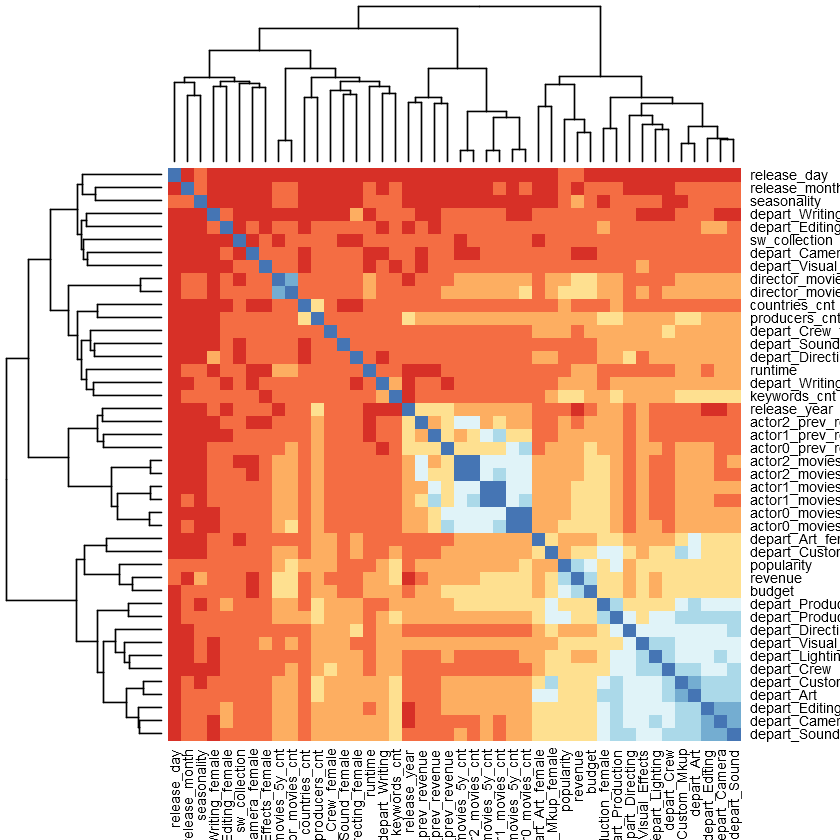

In [20]:
heatmap(res,symm = T,cexCol = 0.8, cexRow = 0.8, col=brewer.pal(n=8, name="RdYlBu"))

In [14]:
if (!require("corrplot")) install.packages("corrplot")
if (!require("RColorBrewer")) install.packages("RColorBrewer")

Loading required package: corrplot

corrplot 0.84 loaded



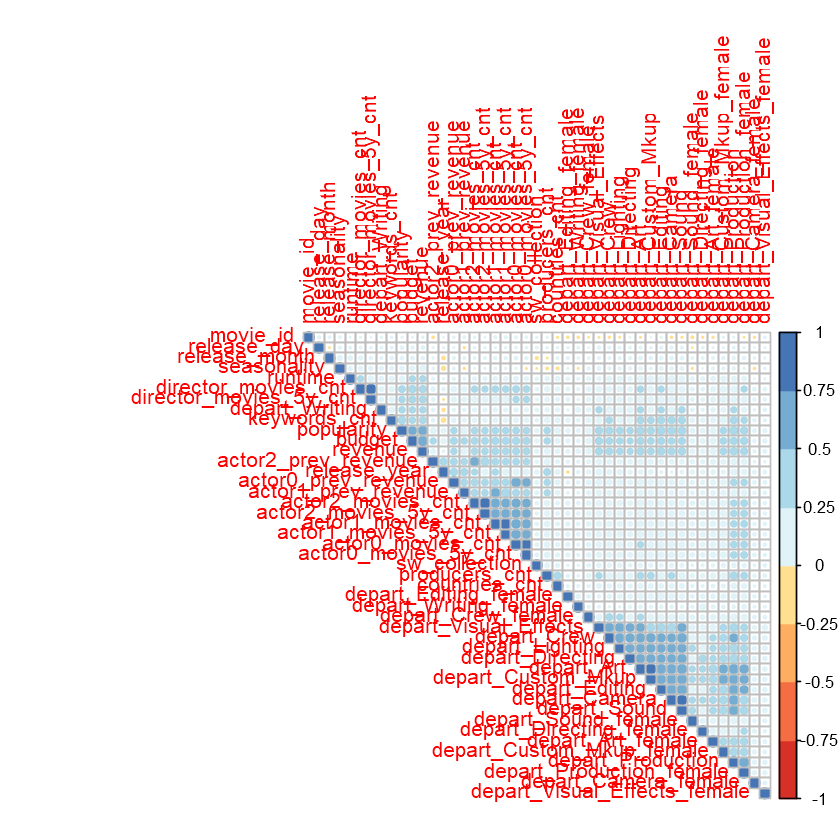

In [15]:
corrplot(res, type="upper", order="hclust", col=brewer.pal(n=8, name="RdYlBu"))

#### 2.4 - Describe the outcome variable

- Histogram
- Histogram by categories


Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


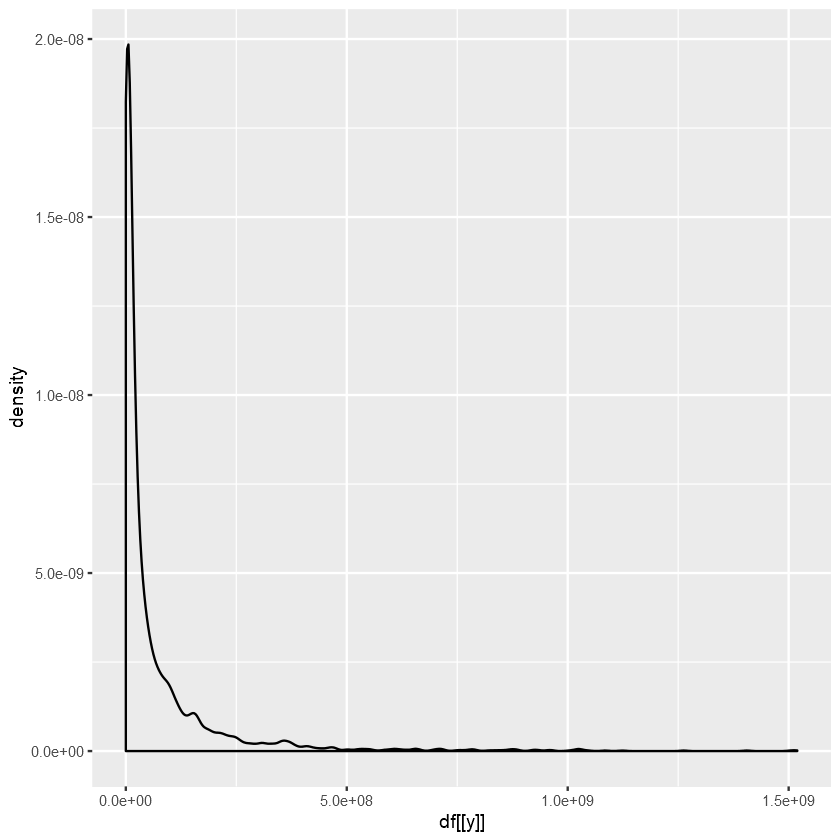

In [16]:
ggplot(data=df) + geom_density(aes(df[[y]]))

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been drop

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

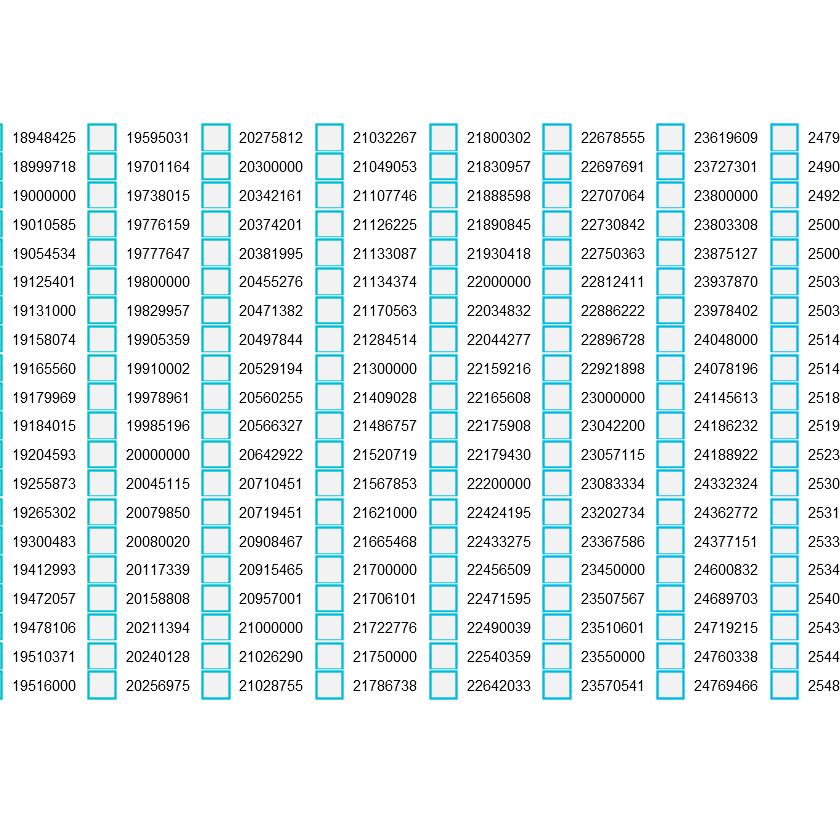

In [21]:
ggplot(data=df) + geom_density(aes(df[[y]], group=factor(df[["revenue"]]), color=factor(df[["revenue"]])))
# Y = revenue, group = movies_categorical

#### 2.5 - Graphs to catch outliers


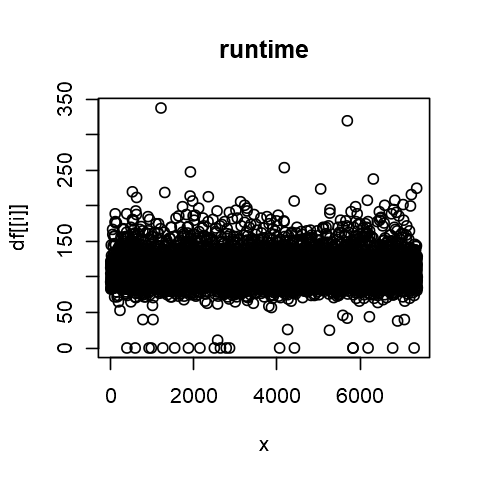

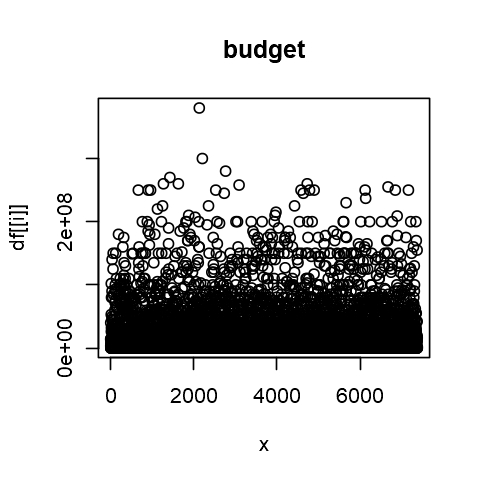

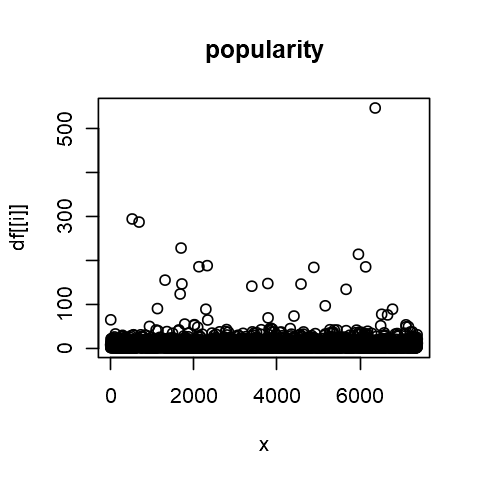

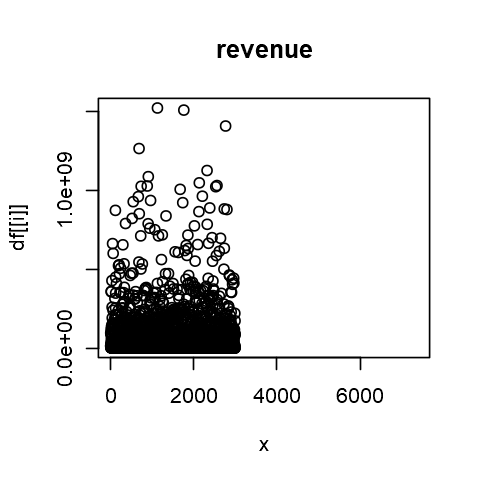

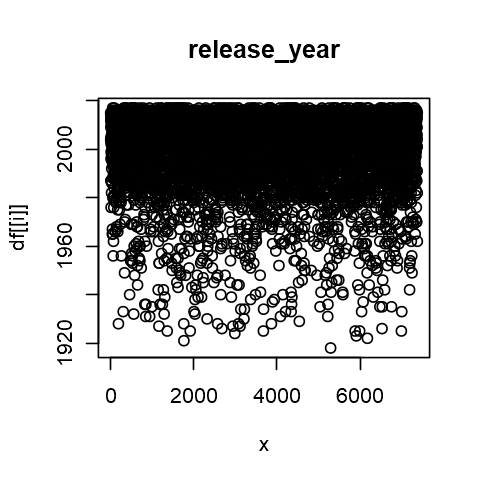

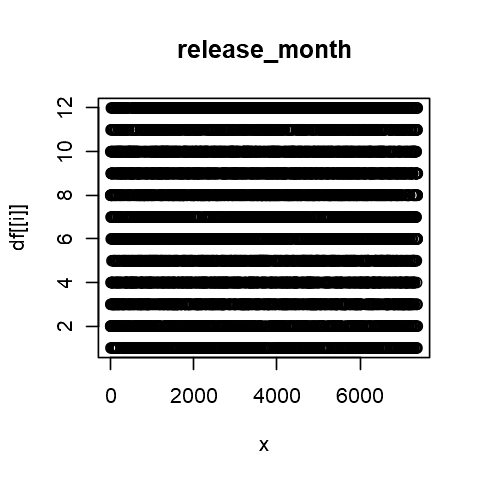

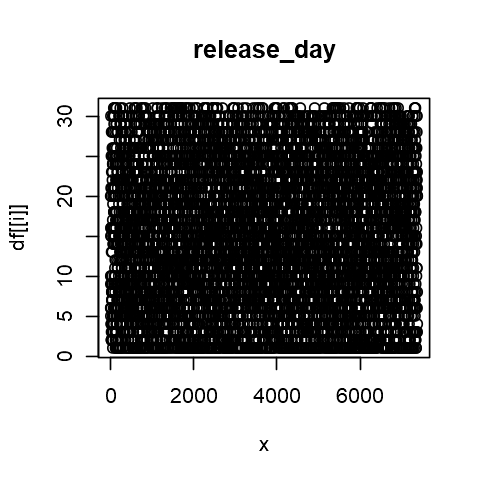

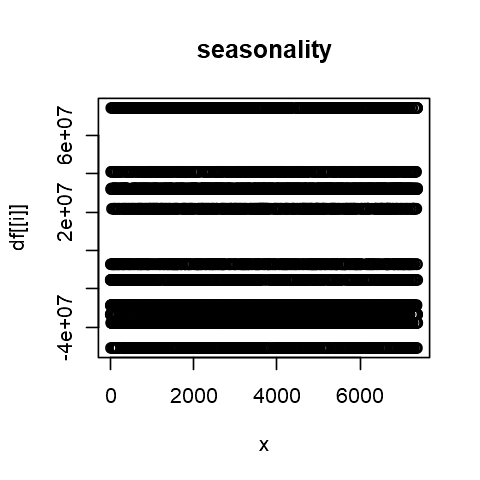

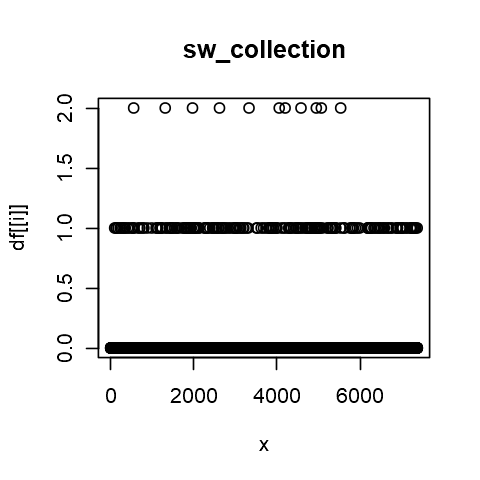

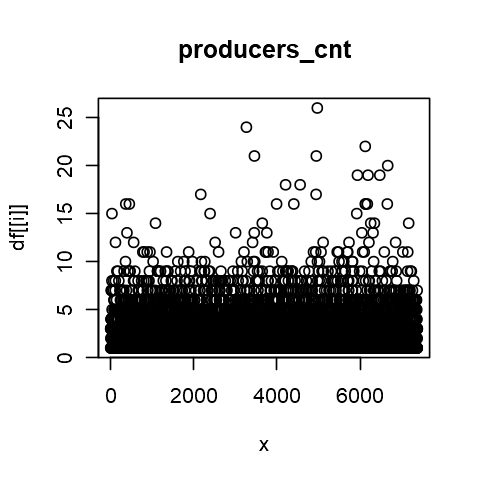

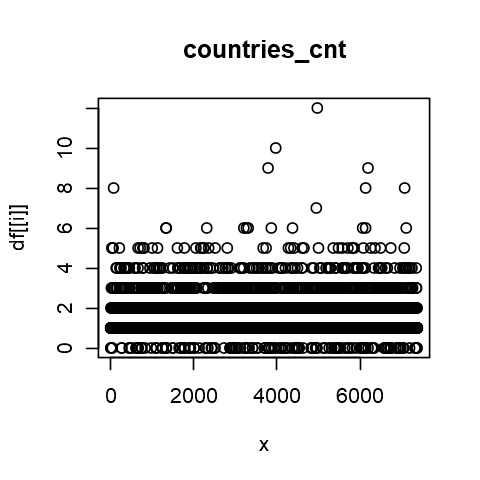

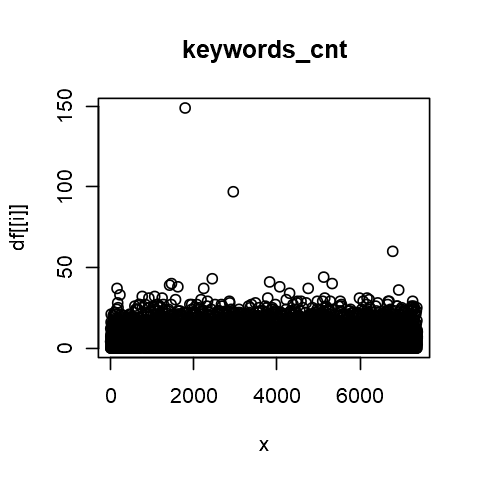

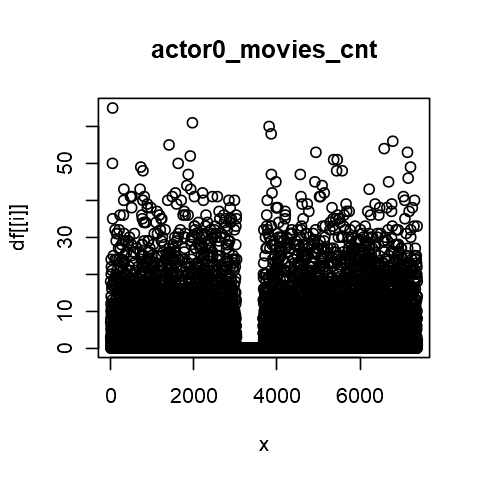

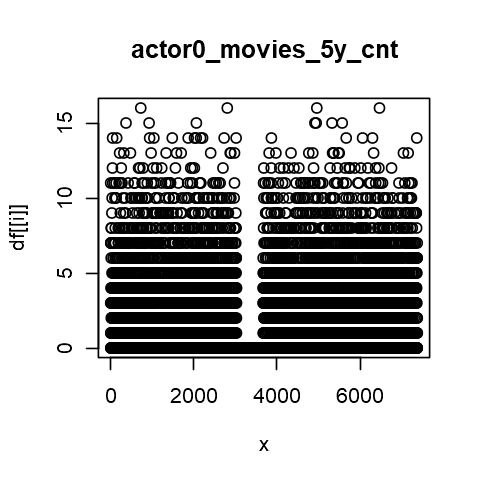

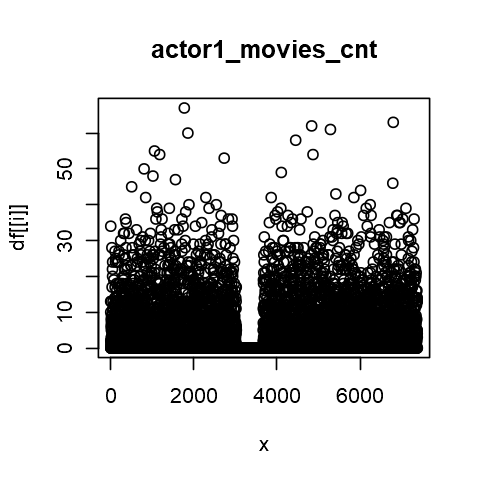

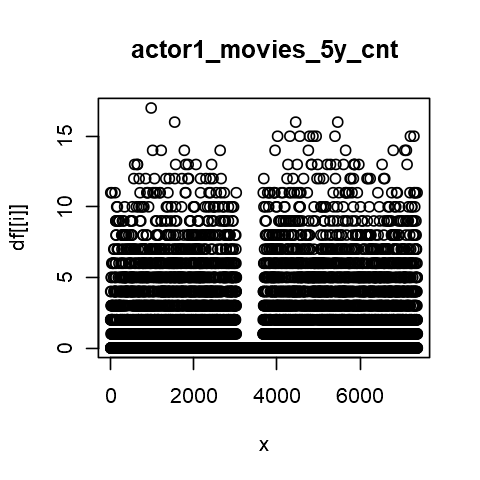

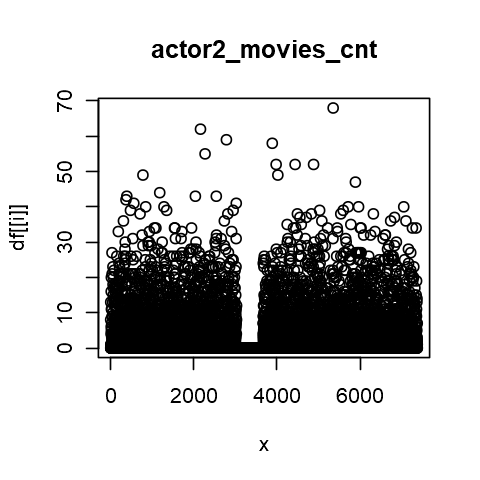

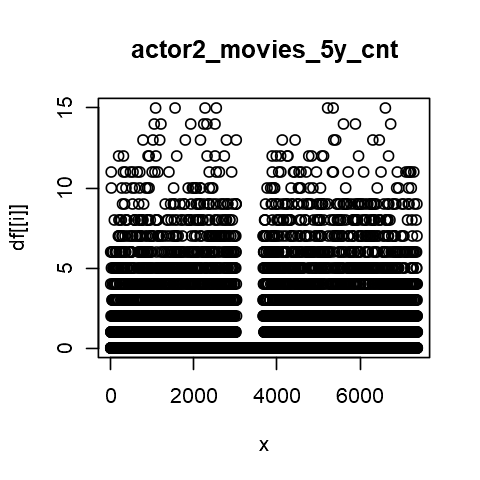

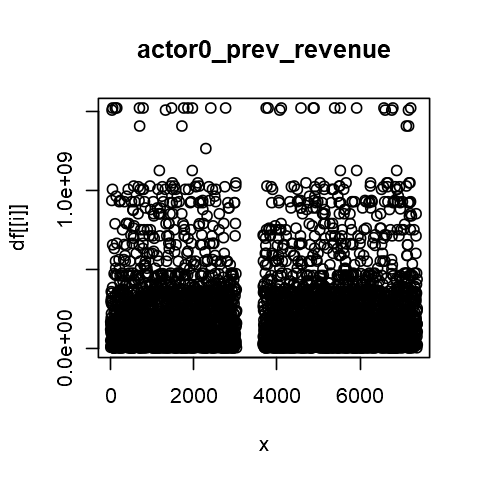

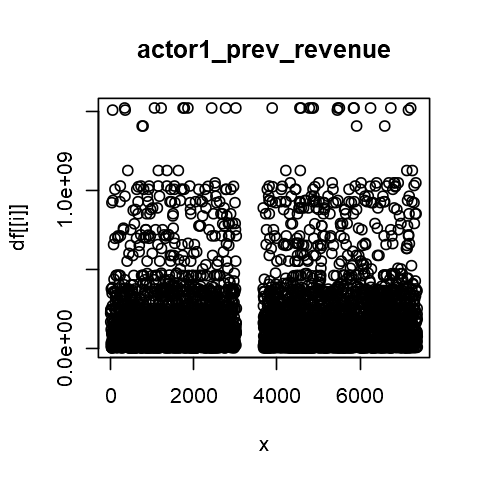

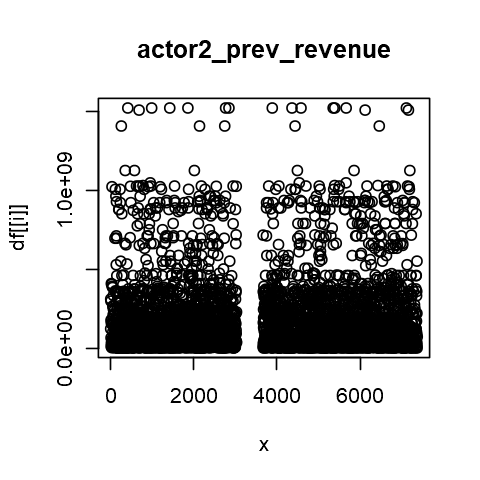

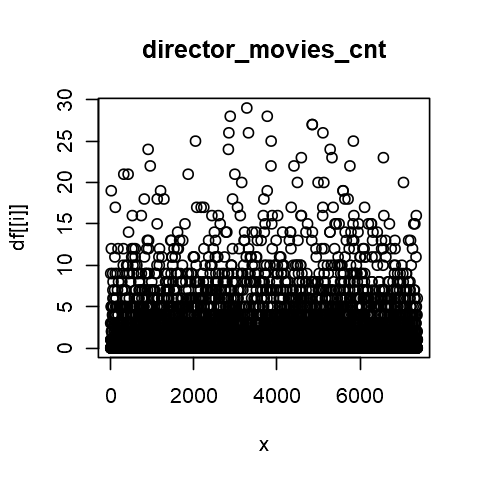

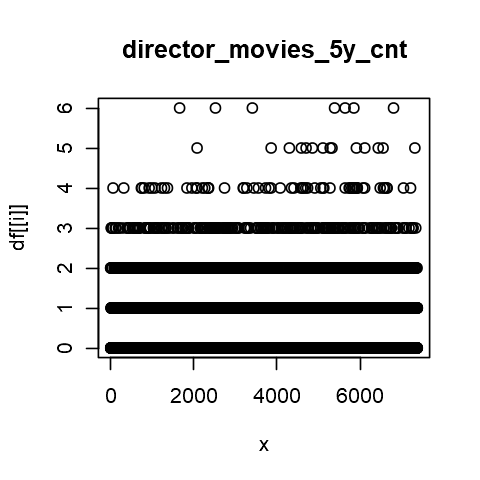

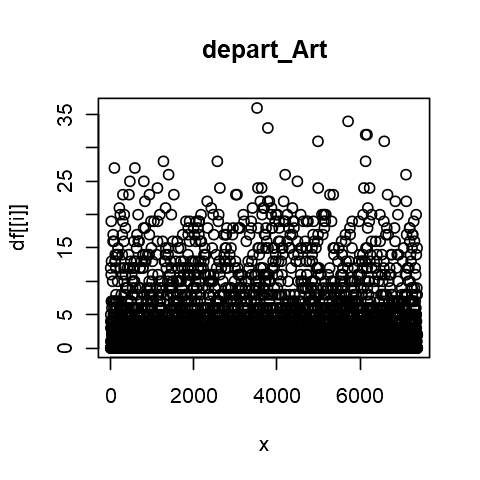

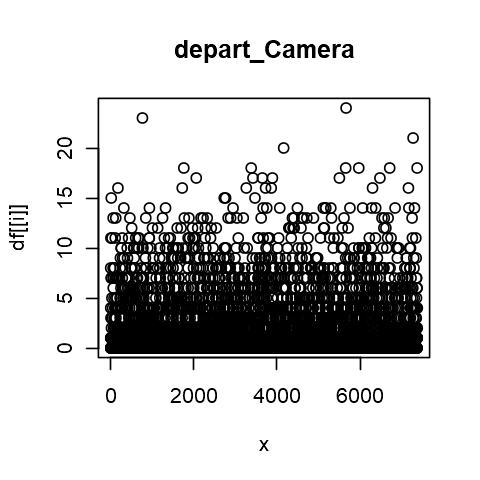

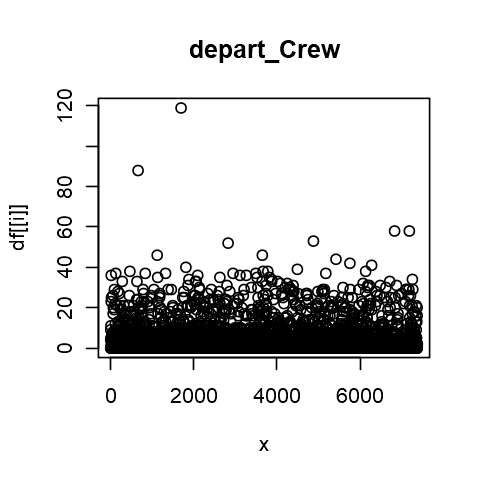

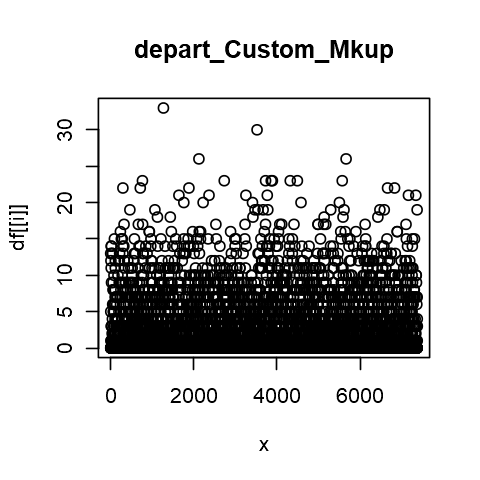

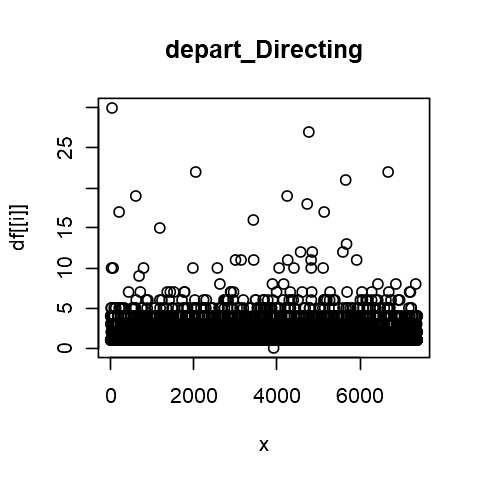

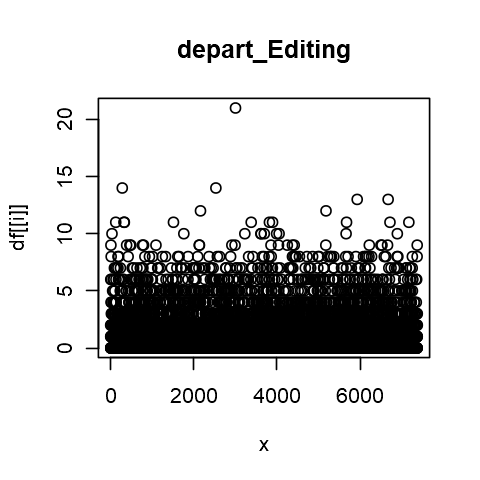

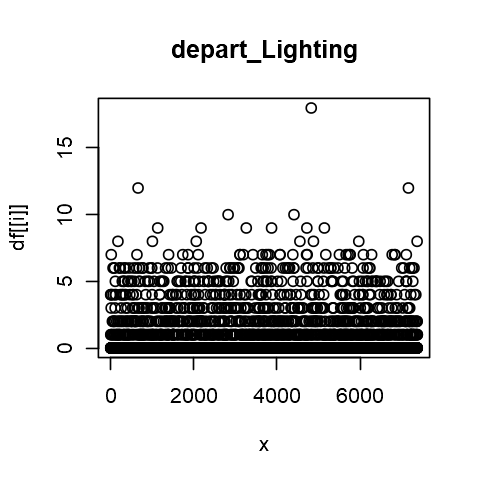

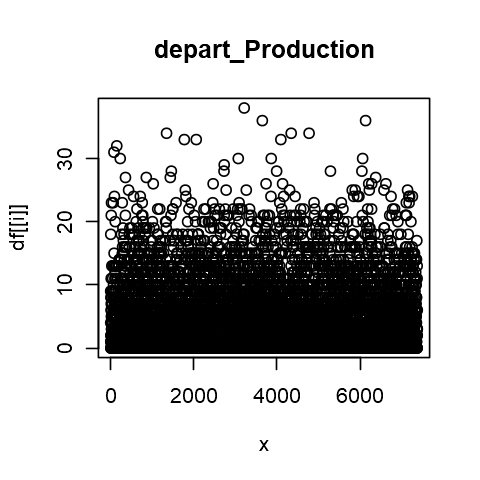

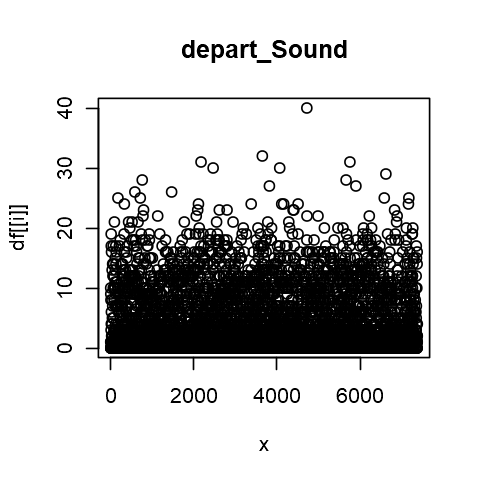

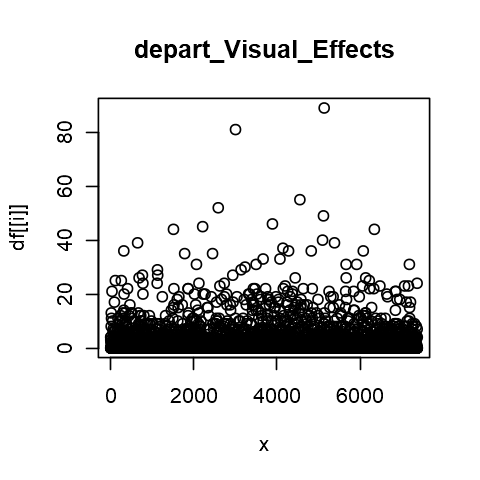

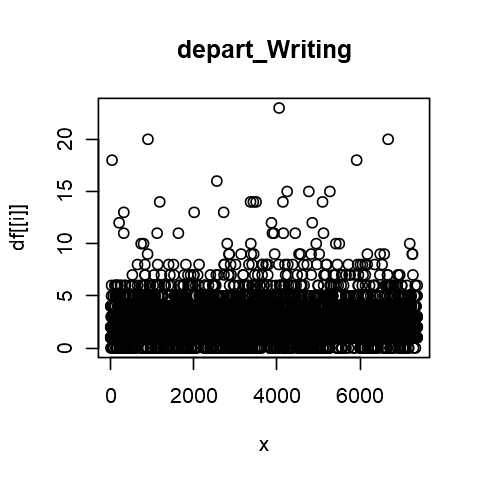

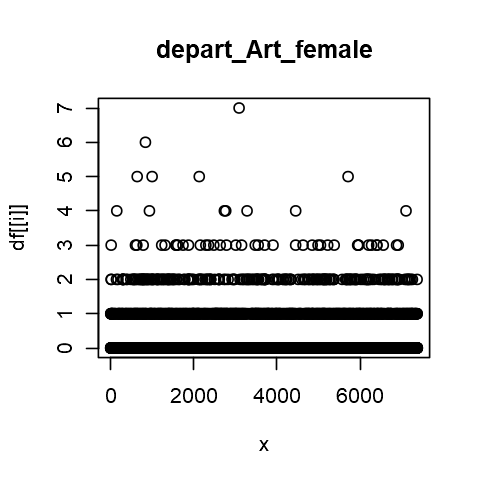

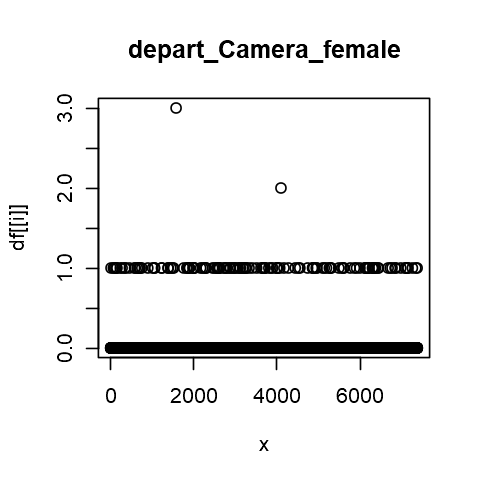

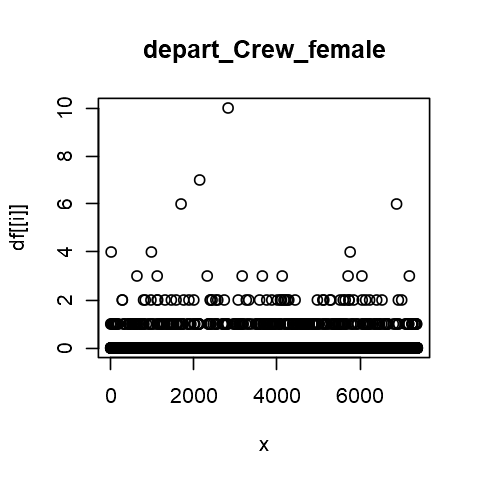

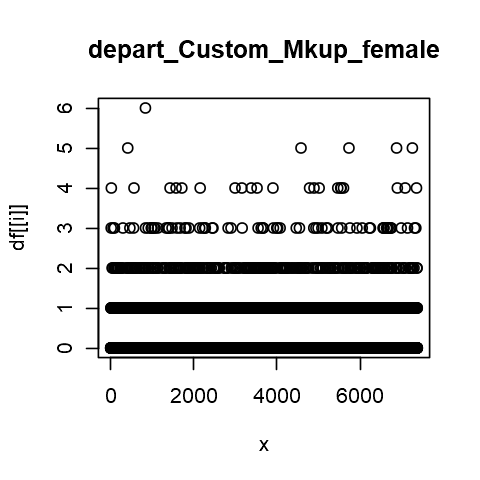

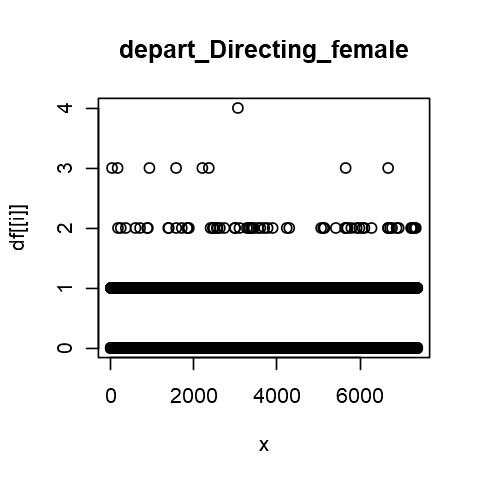

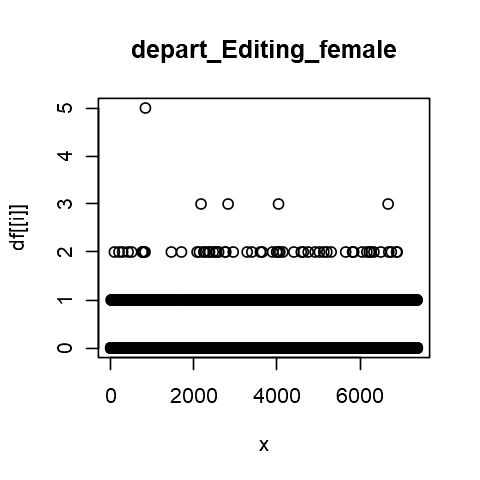

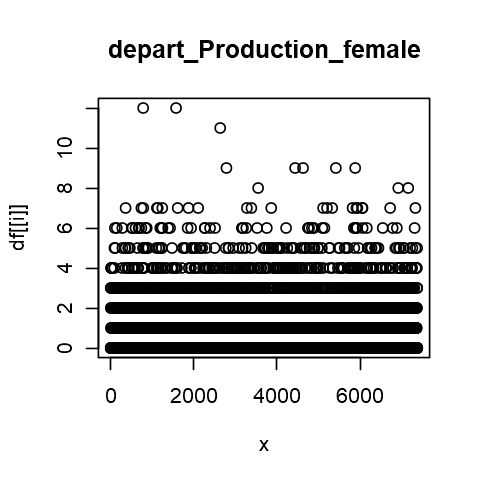

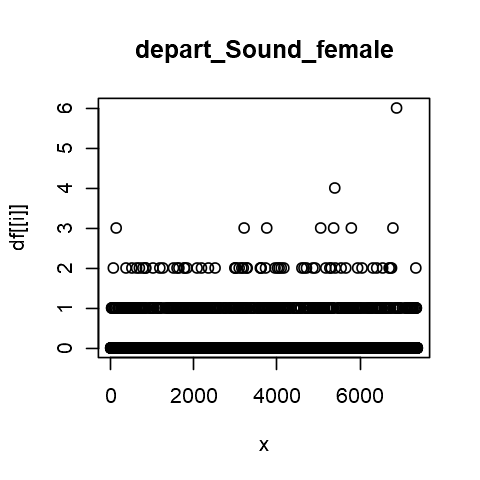

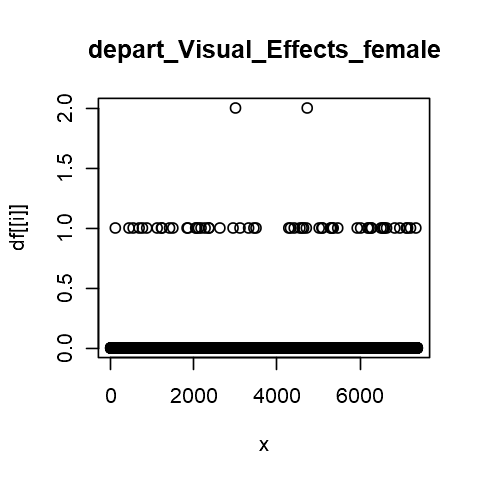

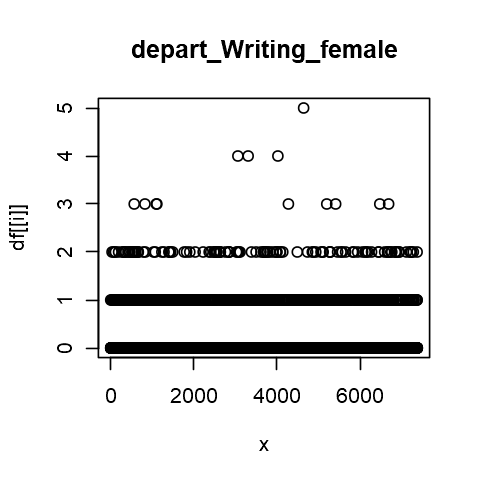

In [22]:
options(repr.plot.width = 4, repr.plot.height = 4)
x <- 1:nrow(df)
for(i in movies_continuous) {
    plot(df[[i]] ~ x, main=i)
}

#### 2.6 -  Describe the missing values

In [23]:
if (!require("dplyr")) install.packages("dplyr")

In [24]:
getMissingness <- function(data, getRows=FALSE) {
  desc <- na_count <- na_cnt <- rn <- pred <- dc <- NULL
  l <- nrow(data)
  vn <- names(data)
  ### copy the dataset and replace the NAs by 1 else 0
  nadf <- data
  cnt <- NULL
  miss <- function(x) return(sum(is.na(x) ))
  for(n in vn) {
    nadf[[n]] <- ifelse(is.na(nadf[[n]])==T,1,0)
    cnt <- rbind(cnt, data.frame(n,sum(nadf[[n]])))
  }
  names(cnt) <- c("var","na_count")
  cnt$rate <- round((cnt$na_count / nrow(nadf))*100,1)
  ### now sum by column
  nadf$na_cnt <- 0
  nadf$na_cnt <- rowSums(nadf)
  ### order descending the count of mossings and leave only those with missings
  cnt <- cnt %>%
    dplyr::arrange(desc(na_count)) %>%
    dplyr::filter(na_count>0)
  totmiss <- nadf %>% dplyr::filter(na_cnt==0) %>% dplyr::summarise(n=n())
  idx <- NULL
  msg <- (paste("This dataset has ", as.character(totmiss), " (",as.character(round(totmiss/nrow(data)*100,1)),"%)" ," complete rows. Original data has ",nrow(data)," rows.",sep=""))
  ### check id needs to return the row indexes
  if(getRows==TRUE & totmiss != 0) {
    nadf$rn <- seq_len(nrow(data))
    idx <- nadf %>% dplyr::filter(na_cnt==0) %>% dplyr::select(rn)
  }
  print(list(head(cnt,n=10), msg))
  return(list(missingness=cnt, message=msg, rows=idx$rn))
}

In [25]:
getMissingness(df)

[[1]]
                   var na_count rate
1              revenue     4382 59.4
2  actor2_prev_revenue     3423 46.4
3  actor1_prev_revenue     3201 43.4
4  actor0_prev_revenue     2752 37.3
5     sw_female_actor0      934 12.7
6       sw_male_actor0      934 12.7
7     sw_female_actor2      788 10.7
8       sw_male_actor2      788 10.7
9     sw_female_actor1      782 10.6
10      sw_male_actor1      782 10.6

[[2]]
[1] "This dataset has 1154 (15.6%) complete rows. Original data has 7375 rows."



$missingness
                            var na_count rate
1                       revenue     4382 59.4
2           actor2_prev_revenue     3423 46.4
3           actor1_prev_revenue     3201 43.4
4           actor0_prev_revenue     2752 37.3
5              sw_female_actor0      934 12.7
6                sw_male_actor0      934 12.7
7              sw_female_actor2      788 10.7
8                sw_male_actor2      788 10.7
9              sw_female_actor1      782 10.6
10               sw_male_actor1      782 10.6
11                producers_cnt      395  5.4
12                   depart_Art       34  0.5
13                depart_Camera       34  0.5
14                  depart_Crew       34  0.5
15           depart_Custom_Mkup       34  0.5
16             depart_Directing       34  0.5
17               depart_Editing       34  0.5
18              depart_Lighting       34  0.5
19            depart_Production       34  0.5
20                 depart_Sound       34  0.5
21        depart_Visual_Effects       34  0.5
22               depart_Writing       34  0.5
23            depart_Art_female       34  0.5
24         depart_Camera_female       34  0.5
25           depart_Crew_female       34  0.5
26    depart_Custom_Mkup_female       34  0.5
27      depart_Directing_female       34  0.5
28        depart_Editing_female       34  0.5
29       depart_Lighting_female       34  0.5
30     depart_Production_female       34  0.5
31          depart_Sound_female       34  0.5
32 depart_Visual_Effects_female       34  0.5
33        depart_Writing_female       34  0.5
34                      runtime        5  0.1
35                 release_date        1  0.0
36                 release_year        1  0.0
37                release_month        1  0.0
38                  release_day        1  0.0
39                  seasonality        1  0.0

$message
[1] "This dataset has 1154 (15.6%) complete rows. Original data has 7375 rows."

$rows
NULL

#### 2.7 - Missing matrix

In [26]:
df.na <- df
for(i in names(df)) {
    df.na[,i] <- ifelse(is.na(df.na[,i])==T,1,0)
}

In [27]:
head(df.na)

movie_id original_language release_date runtime_cat runtime budget popularity
1 0        0                 0            0           0       0      0         
2 0        0                 0            0           0       0      0         
3 0        0                 0            0           0       0      0         
4 0        0                 0            0           0       0      0         
5 0        0                 0            0           0       0      0         
6 0        0                 0            0           0       0      0         
  revenue sw_lang_en sw_web_presence ... depart_Camera_female
1 0       0          0               ... 0                   
2 0       0          0               ... 0                   
3 0       0          0               ... 0                   
4 0       0          0               ... 0                   
5 0       0          0               ... 0                   
6 0       0          0               ... 0                   
  depart_Crew_female depart_Custom_Mkup_female depart_Directing_female
1 0                  0                         0                      
2 0                  0                         0                      
3 0                  0                         0                      
4 0                  0                         0                      
5 0                  0                         0                      
6 0                  0                         0                      
  depart_Editing_female depart_Lighting_female depart_Production_female
1 0                     0                      0                       
2 0                     0                      0                       
3 0                     0                      0                       
4 0                     0                      0                       
5 0                     0                      0                       
6 0                     0                      0                       
  depart_Sound_female depart_Visual_Effects_female depart_Writing_female
1 0                   0                            0                    
2 0                   0                            0                    
3 0                   0                            0                    
4 0                   0                            0                    
5 0                   0                            0                    
6 0                   0                            0

In [28]:
df.na

movie_id original_language release_date runtime_cat runtime budget
1    0        0                 0            0           0       0     
2    0        0                 0            0           0       0     
3    0        0                 0            0           0       0     
4    0        0                 0            0           0       0     
5    0        0                 0            0           0       0     
6    0        0                 0            0           0       0     
7    0        0                 0            0           0       0     
8    0        0                 0            0           0       0     
9    0        0                 0            0           0       0     
10   0        0                 0            0           0       0     
11   0        0                 0            0           0       0     
12   0        0                 0            0           0       0     
13   0        0                 0            0           0       0     
14   0        0                 0            0           0       0     
15   0        0                 0            0           0       0     
16   0        0                 0            0           0       0     
17   0        0                 0            0           0       0     
18   0        0                 0            0           0       0     
19   0        0                 0            0           0       0     
20   0        0                 0            0           0       0     
21   0        0                 0            0           0       0     
22   0        0                 0            0           0       0     
23   0        0                 0            0           0       0     
24   0        0                 0            0           0       0     
25   0        0                 0            0           0       0     
26   0        0                 0            0           0       0     
27   0        0                 0            0           0       0     
28   0        0                 0            0           0       0     
29   0        0                 0            0           0       0     
30   0        0                 0            0           0       0     
...  ...      ...               ...          ...         ...     ...   
7346 0        0                 0            0           0       0     
7347 0        0                 0            0           0       0     
7348 0        0                 0            0           0       0     
7349 0        0                 0            0           0       0     
7350 0        0                 0            0           0       0     
7351 0        0                 0            0           0       0     
7352 0        0                 0            0           0       0     
7353 0        0                 0            0           0       0     
7354 0        0                 0            0           0       0     
7355 0        0                 0            0           0       0     
7356 0        0                 0            0           0       0     
7357 0        0                 0            0           0       0     
7358 0        0                 0            0           0       0     
7359 0        0                 0            0           0       0     
7360 0        0                 0            0           0       0     
7361 0        0                 0            0           0       0     
7362 0        0                 0            0           0       0     
7363 0        0                 0            0           0       0     
7364 0        0                 0            0           0       0     
7365 0        0                 0            0           0       0     
7366 0        0                 0            0           0       0     
7367 0        0                 0            0           0       0     
7368 0        0                 0            0           0       0     
7369 0        0                 0            

Warning message in brewer.pal(n = ncol(df), name = "RdYlBu"):
"n too large, allowed maximum for palette RdYlBu is 11
Returning the palette you asked for with that many colors
"


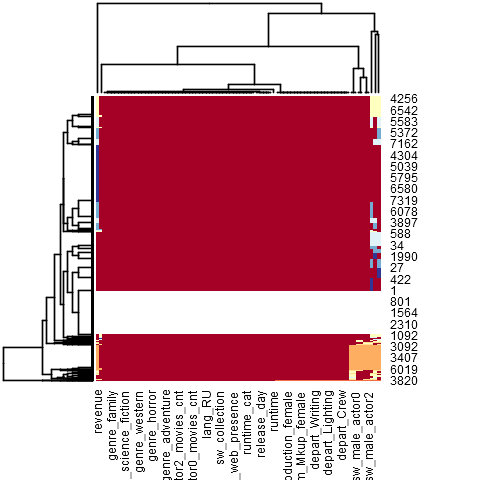

In [30]:
heatmap(as.matrix(df.na),cexCol = 0.7, cexRow = 0.7, col=brewer.pal(n=ncol(df), name="RdYlBu"))

In [31]:
if (!require("VIM")) install.packages("VIM")

Loading required package: VIM

Loading required package: colorspace

Loading required package: grid

Loading required package: data.table

Warning message:
"package 'data.table' was built under R version 3.6.2"

Attaching package: 'data.table'


The following objects are masked from 'package:dplyr':

    between, first, last


VIM is ready to use. 
 Since version 4.0.0 the GUI is in its own package VIMGUI.

          Please use the package to use the new (and old) GUI.


Suggestions and bug-reports can be submitted at: https://github.com/alexkowa/VIM/issues


Attaching package: 'VIM'


The following object is masked from 'package:datasets':

    sleep




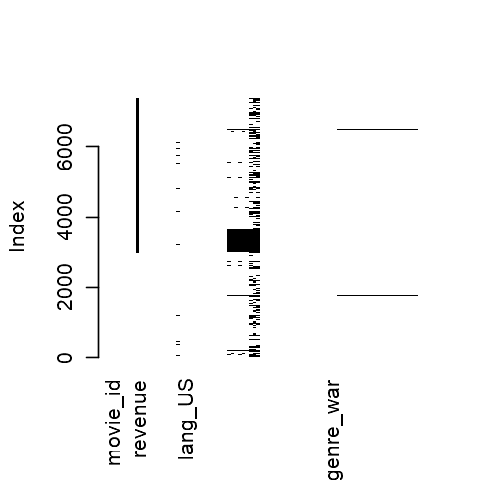

In [32]:
matrixplot(as.matrix(df.na))

## 3 - Data Cleansing
 
### 3.1 -  Outliers

#### 3.1.1 - For the variables where outliers were found, check the distribution with/without outliers


[1] 5.424 5.345

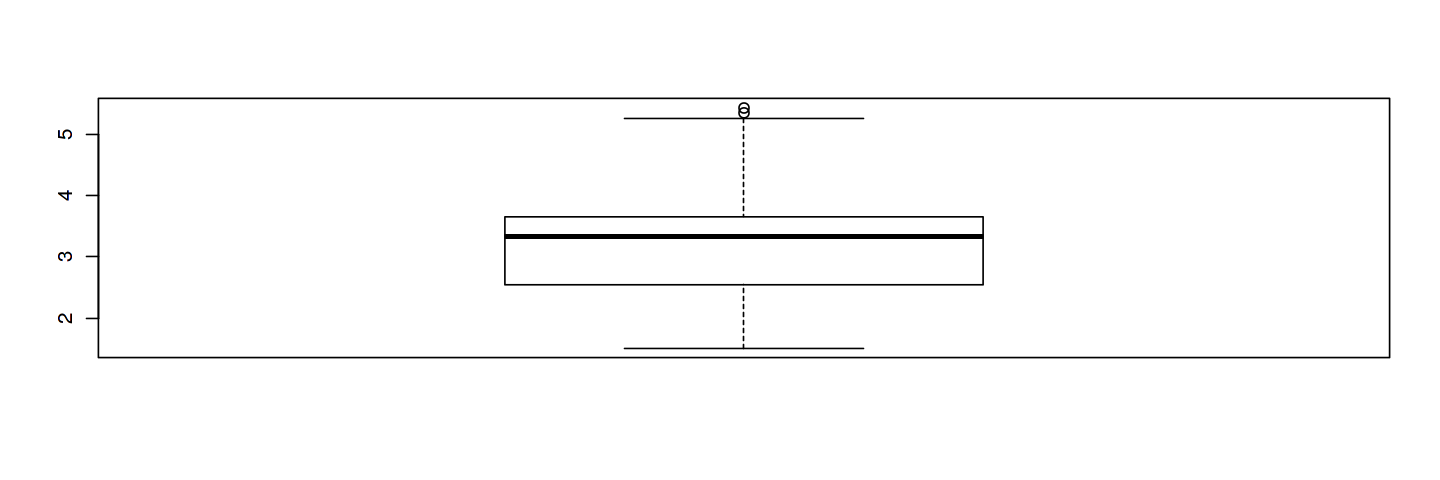

In [131]:
out <- boxplot(df["wt"])
out$out

In [146]:
wt.out <- ifelse(df[["wt"]] >= 5,1,0)
table(wt.out)

wt.out
 0  1 
29  3 

In [148]:
wt.noout <- df[['wt']]
wt.noout <- ifelse(wt.out==1,NA,wt.noout)
wt.noout

[1] 2.620 2.875 2.320 3.215 3.440 3.460 3.570 3.190 3.150 3.440 3.440 4.070
[13] 3.730 3.780    NA    NA    NA 2.200 1.615 1.835 2.465 3.520 3.435 3.840
[25] 3.845 1.935 2.140 1.513 3.170 2.770 3.570 2.780

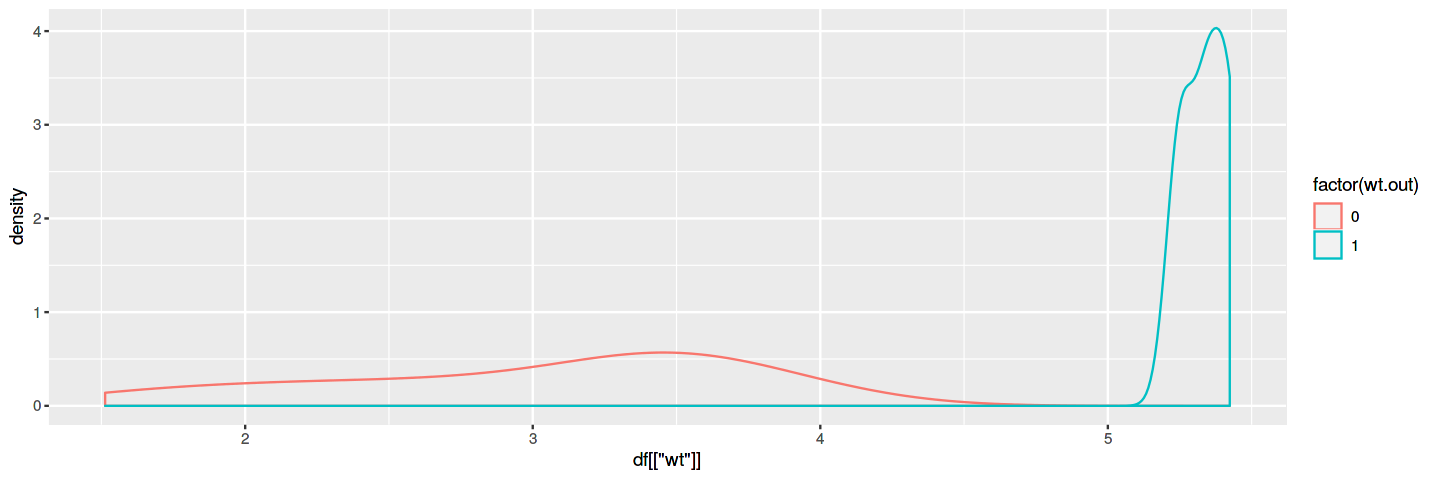

In [147]:
ggplot() + 
geom_density(aes(df[["budget"]], group=factor(wt.out), color=factor(wt.out)))
# this is the regression plot

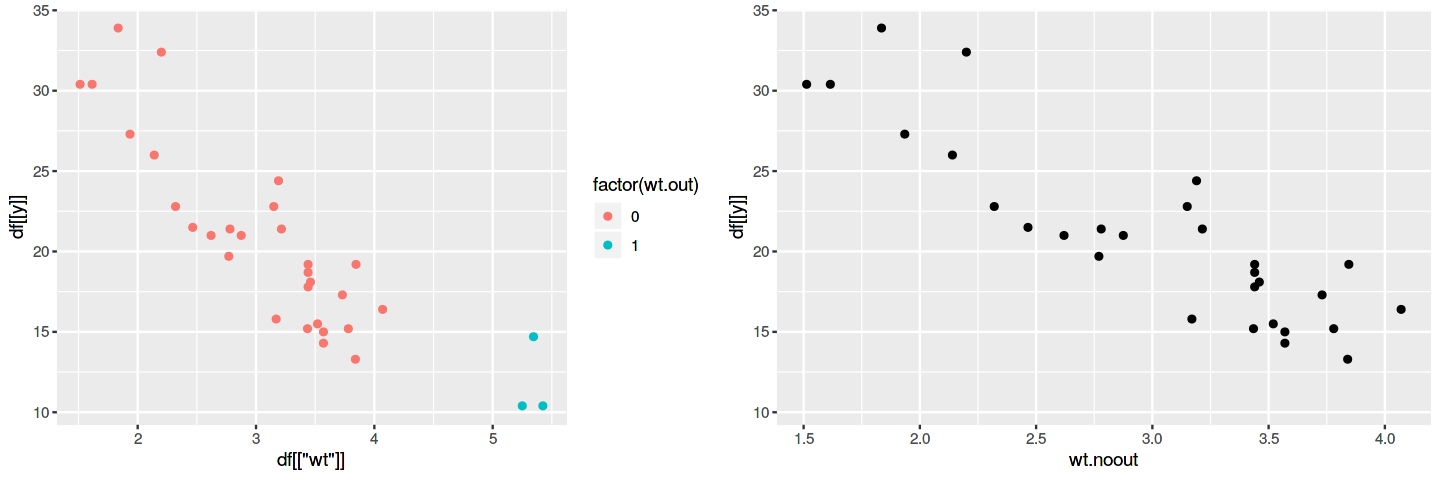

In [149]:
p1 <- ggplot() + geom_point(aes(x=df[['wt']], y=df[[y]], color=factor(wt.out)))
p2 <- ggplot() + geom_point(aes(x=wt.noout, y=df[[y]]))
grid.arrange(p1, p2, nrow = 1)


#### 3.1.2 - Influence of the outluers on the outcome

In [150]:
mod1 <- lm(df[[y]] ~ df[['wt']])
mod2 <- lm(df[[y]] ~ wt.noout)


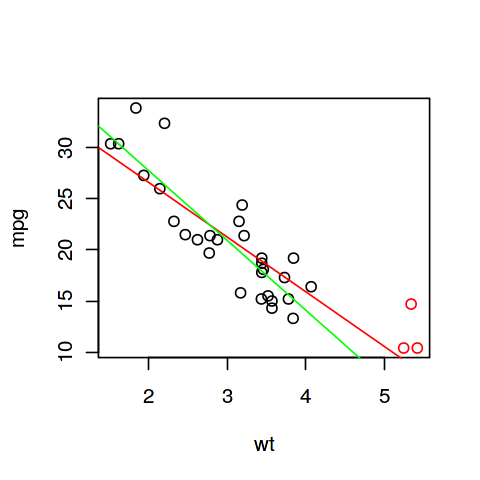

In [161]:
options(repr.plot.width = 4, repr.plot.height = 4)
plot(df[['wt']], df[[y]], col=factor(wt.out),xlab="wt",ylab=y)
abline(mod1, col="red") 
abline(mod2, col="green")
# this is the result plot

#### 3.1.3 - Table with variables having outliers.  

In [162]:
outres <- data.frame(variable=NULL,treatment=NULL,why=NULL)
outres

<0 x 0 matrix>

#### 3.1.4 - Cleansed dataset for Outliers

In [163]:
df.noout <- df
## here treat the outliers as described in 3.1.3

### 3.2 - Missing values
 
#### 3.2.1 - Show the distribution of each numeric variable by missingness of other variables 

In [ ]:
## save the original table into another table and put the dataset after the outlier treatment into df
df.orig <- df
df <- df.noout

In [ ]:
## remade the missing matrix to include the new missing values generated by the outliers treatment
df.na <- df
for(i in names(df)) {
    df.na[,i] <- ifelse(is.na(df.na[,i])==T,1,0)
}

In [167]:
## just converted the categorical variable to factors...
df$vs <- factor(df$vs)
df$am <- factor(df$am)
summary(df)

      mpg             cyl             disp             hp       
 Min.   :10.40   Min.   :4.000   Min.   : 71.1   Min.   : 52.0  
 1st Qu.:15.43   1st Qu.:4.000   1st Qu.:120.8   1st Qu.: 96.5  
 Median :19.20   Median :6.000   Median :196.3   Median :123.0  
 Mean   :20.09   Mean   :6.188   Mean   :230.7   Mean   :146.7  
 3rd Qu.:22.80   3rd Qu.:8.000   3rd Qu.:326.0   3rd Qu.:180.0  
 Max.   :33.90   Max.   :8.000   Max.   :472.0   Max.   :335.0  
                                                                
      drat             wt             qsec       vs     am          gear      
 Min.   :2.760   Min.   :1.513   Min.   :14.50   0:18   0:19   Min.   :3.000  
 1st Qu.:3.080   1st Qu.:2.581   1st Qu.:16.89   1:14   1:13   1st Qu.:3.000  
 Median :3.690   Median :3.325   Median :17.51                 Median :4.000  
 Mean   :3.587   Mean   :3.217   Mean   :17.81                 Mean   :3.688  
 3rd Qu.:3.920   3rd Qu.:3.610   3rd Qu.:18.68                 3rd Qu.:4.000  
 Max. 

In [165]:
head(df.na)

mpg cyl disp hp drat wt qsec vs am gear carb
Mazda RX4         0   0   0    0  0    0  0    0  0  0    0   
Mazda RX4 Wag     0   0   0    0  1    0  0    0  0  0    0   
Datsun 710        0   0   0    0  0    0  0    0  0  0    0   
Hornet 4 Drive    0   0   0    0  0    0  0    0  0  0    0   
Hornet Sportabout 0   0   0    0  0    0  0    0  0  0    0   
Valiant           0   0   0    0  0    0  1    0  0  0    0

[1] "drat by vs"
[1] "drat by am"


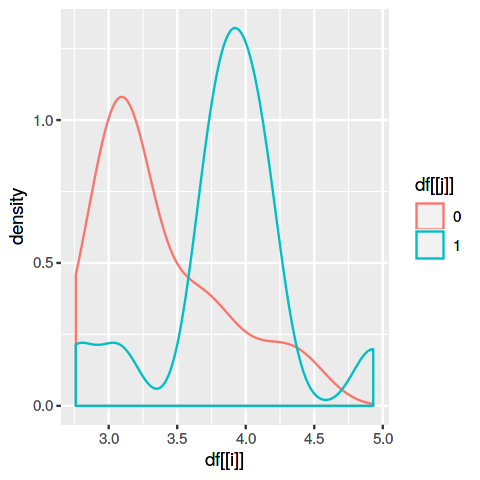

[1] "qsec by vs"


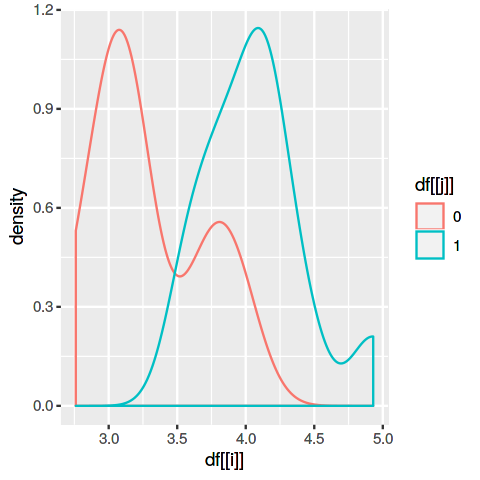

[1] "qsec by am"


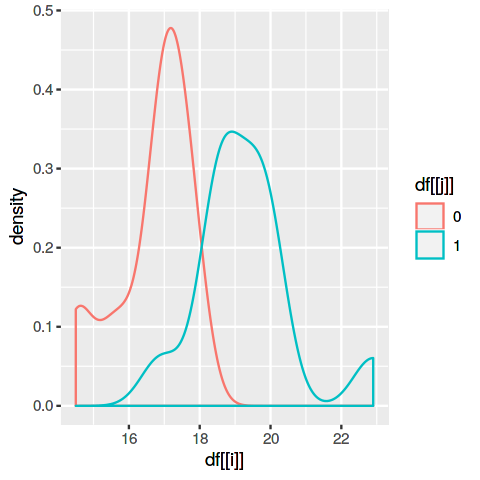

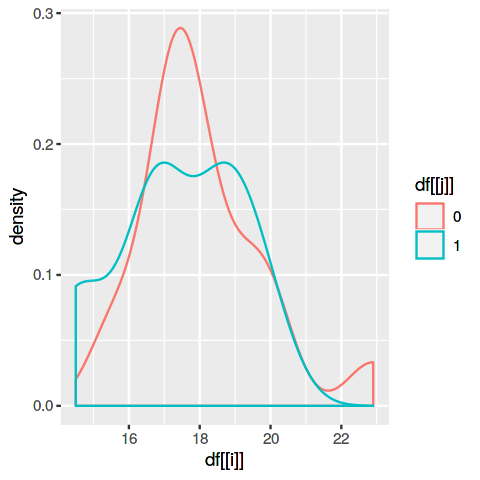

In [171]:
nm <- names(df)
## iterate through the variables
for(i in 1:length(nm)) {
    for(j in 1:length(nm)) {
        ## check if i and j are the same
        if(i!=j) {
            ## check if the variable is numeric and has missing values
            if(is.numeric(df[[i]])==TRUE & sum(df.na[[i]])>0) {
                ## if the j variable is a factor print a differential distribution plot
                if(is.factor(df[[j]])) {
                    print(paste(nm[i],"by",nm[j]))
                    p1 <- ggplot() + geom_density(aes(df[[i]],group=df[[j]],color=df[[j]]))
                    plot(p1)
                }
            }
        }
    }
}


#### 3.2.2 - Missingness table with explanatory mechanisms

In [172]:
missres <- data.frame(variable=NULL,mechanism=NULL,treatment=NULL)
missres

<0 x 0 matrix>

#### 3.2.3 - Missingess treatment

In [ ]:
df.final <- df
## here treat the outliers as described in 3.1.3

### 4 - Repeat the EDA to ensure that everything is Ok and the dataset is ready for model generation
 
In this phase, we have to make the following steps:

1. Descriptive Statistics
2. Data visualization
